In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
train_mod1_X = input_train_mod1.X.toarray()
train_mod1_X.shape

(66175, 13953)

In [9]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [10]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [11]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [12]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [13]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [14]:
batch_total = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)+list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)+list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [15]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [16]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [17]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [18]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [19]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [20]:
RNA_total = np.concatenate([RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9], axis=0)

In [21]:
pca = PCA(n_components=300)
RNA_total_pca = pca.fit_transform(RNA_total)

In [22]:
RNA_total_pca_pd = pd.DataFrame(RNA_total_pca)
RNA_total_pca_pd['batch'] = batch_total

In [23]:
RNA_s1d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d1'].iloc[:, :-1].to_numpy()
RNA_s1d2 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d2'].iloc[:, :-1].to_numpy()
RNA_s1d3 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s1d3'].iloc[:, :-1].to_numpy()
RNA_s2d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d1'].iloc[:, :-1].to_numpy()
RNA_s2d4 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d4'].iloc[:, :-1].to_numpy()
RNA_s2d5 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s2d5'].iloc[:, :-1].to_numpy()

RNA_s3d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d1'].iloc[:, :-1].to_numpy()
RNA_s3d6 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d6'].iloc[:, :-1].to_numpy()
RNA_s3d7 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s3d7'].iloc[:, :-1].to_numpy()

RNA_s4d1 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d1'].iloc[:, :-1].to_numpy()
RNA_s4d8 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d8'].iloc[:, :-1].to_numpy()
RNA_s4d9 = RNA_total_pca_pd[RNA_total_pca_pd['batch']=='s4d9'].iloc[:, :-1].to_numpy()

In [24]:
# batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
# batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
# batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [25]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [26]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [27]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [28]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [29]:
input_feature = RNA_s1d1.shape[1]
# output_feature = pred_num

In [30]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [31]:
PATH = 'No_norm_model_RNA_pro'

In [32]:
# def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
def fit(num_epochs, model, loss_fn, RNA, pro):
    
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

        if epoch % 100 == 0:
            model = model.eval()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
#             if val_loss < val_best:
#                 torch.save(model.state_dict(), PATH)
#                 val_best = val_loss
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            print('Epoch ', epoch, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:', s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 12, figsize = (30, 3))
            for i in range(1):
                ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('s1d1 result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')

                ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d2 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d3 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
                
                ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s2d1 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')

                ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d4 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d5 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')
                
                ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s3d1 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')

                ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d6 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d7 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')
                
                ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s4d1 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')

                ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d8 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d9 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 s1d1:  0.26827624 s1d2:  0.26300293 s1d3:  0.28126755 s2d1: 1.2574625 s2d4: 0.9554085 s2d5: 0.527732 s3d1: 0.59372693 s3d6: 0.59191334 s3d7: 0.40531805 s4d1: 0.4789705 s4d8: 0.441003 s4d9: 1.2843671 test loss: 0.9349052532150055


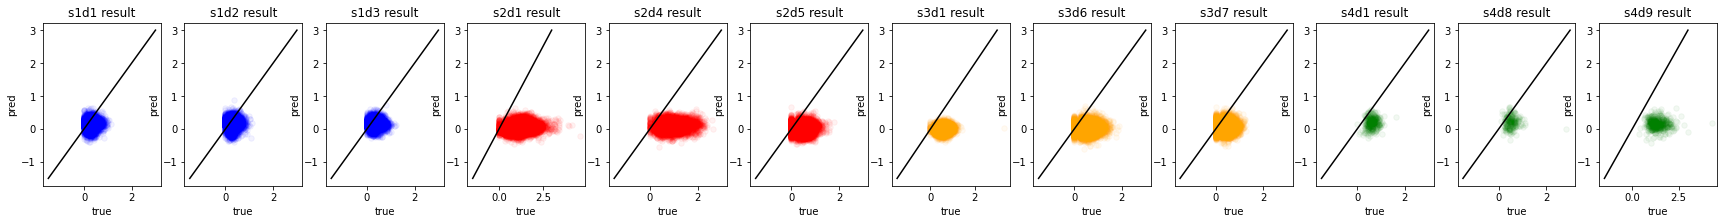

Epoch  100 s1d1:  0.18406211 s1d2:  0.1926335 s1d3:  0.21577246 s2d1: 1.1822927 s2d4: 0.8302004 s2d5: 0.45695525 s3d1: 0.59625506 s3d6: 0.5246375 s3d7: 0.31577376 s4d1: 0.38188896 s4d8: 0.3555329 s4d9: 1.1952622 test loss: 0.8547671999549424
Epoch  200 s1d1:  0.17818274 s1d2:  0.18445793 s1d3:  0.20860474 s2d1: 1.1624917 s2d4: 0.8189985 s2d5: 0.4412621 s3d1: 0.5911769 s3d6: 0.50595516 s3d7: 0.306368 s4d1: 0.37434956 s4d8: 0.346991 s4d9: 1.1788559 test loss: 0.8423788934444449
Epoch  300 s1d1:  0.17507721 s1d2:  0.18014672 s1d3:  0.2039886 s2d1: 1.1494486 s2d4: 0.81265146 s2d5: 0.4303352 s3d1: 0.58320916 s3d6: 0.49379233 s3d7: 0.3005197 s4d1: 0.37061873 s4d8: 0.34266132 s4d9: 1.170629 test loss: 0.8361721191309662
Epoch  400 s1d1:  0.17297535 s1d2:  0.17751816 s1d3:  0.20127253 s2d1: 1.1401639 s2d4: 0.8090852 s2d5: 0.4220941 s3d1: 0.57490736 s3d6: 0.4852753 s3d7: 0.2964633 s4d1: 0.3695712 s4d8: 0.3410669 s4d9: 1.1667829 test loss: 0.8334103105198598
Epoch  500 s1d1:  0.17162809 s1d2:  0

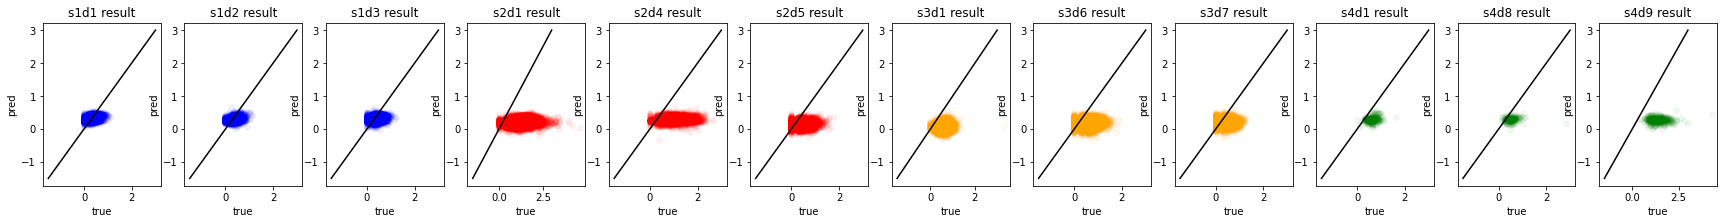

Epoch  1100 s1d1:  0.16829136 s1d2:  0.17187959 s1d3:  0.19325858 s2d1: 1.10648 s2d4: 0.7986945 s2d5: 0.3942111 s3d1: 0.5308398 s3d6: 0.45813698 s3d7: 0.28465956 s4d1: 0.3705568 s4d8: 0.3417095 s4d9: 1.161092 test loss: 0.8299557864703073
Epoch  1200 s1d1:  0.16804312 s1d2:  0.17158099 s1d3:  0.1927656 s2d1: 1.1040161 s2d4: 0.7980724 s2d5: 0.3924879 s3d1: 0.5284525 s3d6: 0.45655075 s3d7: 0.28417423 s4d1: 0.37041712 s4d8: 0.34152254 s4d9: 1.1606531 test loss: 0.8296371619441102
Epoch  1300 s1d1:  0.1678404 s1d2:  0.1713967 s1d3:  0.19233191 s2d1: 1.1018109 s2d4: 0.7974737 s2d5: 0.39078063 s3d1: 0.5264202 s3d6: 0.4549941 s3d7: 0.28364563 s4d1: 0.37013334 s4d8: 0.34129727 s4d9: 1.1601087 test loss: 0.8292260500904814
Epoch  1400 s1d1:  0.16765921 s1d2:  0.17130984 s1d3:  0.19204761 s2d1: 1.1000819 s2d4: 0.79712296 s2d5: 0.38936695 s3d1: 0.5245008 s3d6: 0.4539016 s3d7: 0.2832552 s4d1: 0.37020606 s4d8: 0.34141156 s4d9: 1.1600169 test loss: 0.8291877058454395
Epoch  1500 s1d1:  0.16748856 s1

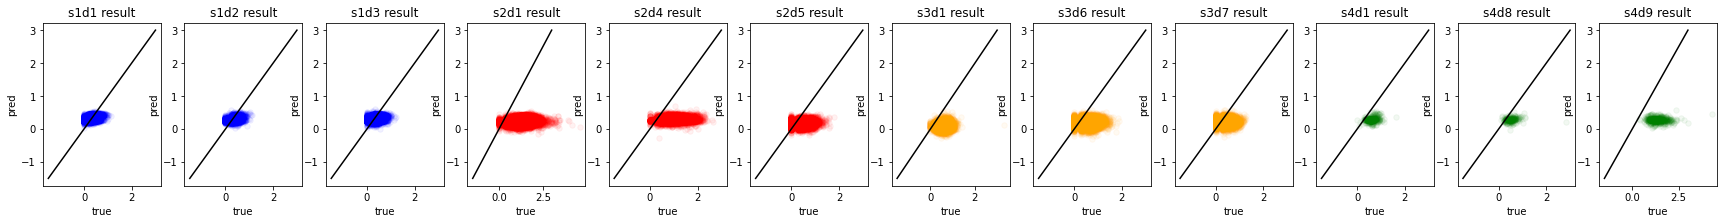

Epoch  2100 s1d1:  0.16663548 s1d2:  0.170738 s1d3:  0.19079512 s2d1: 1.0926208 s2d4: 0.7960491 s2d5: 0.38351595 s3d1: 0.5133031 s3d6: 0.45147467 s3d7: 0.2825337 s4d1: 0.3713678 s4d8: 0.342726 s4d9: 1.1602426 test loss: 0.8296182641678335
Epoch  2200 s1d1:  0.16651452 s1d2:  0.1706995 s1d3:  0.19072492 s2d1: 1.0919652 s2d4: 0.795976 s2d5: 0.38294384 s3d1: 0.5127481 s3d6: 0.45134827 s3d7: 0.28251034 s4d1: 0.3715262 s4d8: 0.34288764 s4d9: 1.1602261 test loss: 0.8296452249741108
Epoch  2300 s1d1:  0.16639522 s1d2:  0.1706612 s1d3:  0.19060828 s2d1: 1.0911665 s2d4: 0.7957674 s2d5: 0.38229164 s3d1: 0.5120631 s3d6: 0.45119298 s3d7: 0.282438 s4d1: 0.3714377 s4d8: 0.34277642 s4d9: 1.1600325 test loss: 0.8294982069303236
Epoch  2400 s1d1:  0.16627318 s1d2:  0.17061496 s1d3:  0.19056274 s2d1: 1.0906065 s2d4: 0.79590964 s2d5: 0.38182172 s3d1: 0.51105994 s3d6: 0.4513073 s3d7: 0.28254116 s4d1: 0.37168723 s4d8: 0.34297857 s4d9: 1.1602534 test loss: 0.8296946022929432
Epoch  2500 s1d1:  0.1661644 s1d

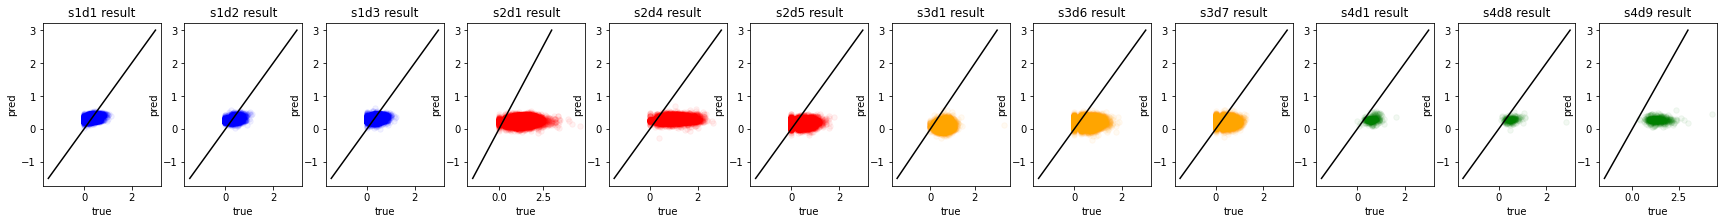

Epoch  3100 s1d1:  0.16550404 s1d2:  0.17047158 s1d3:  0.19036442 s2d1: 1.0884943 s2d4: 0.79697543 s2d5: 0.37910938 s3d1: 0.509281 s3d6: 0.45262086 s3d7: 0.28320497 s4d1: 0.37315577 s4d8: 0.34391248 s4d9: 1.1611552 test loss: 0.830573419948345
Epoch  3200 s1d1:  0.16538984 s1d2:  0.17043564 s1d3:  0.19028252 s2d1: 1.0881802 s2d4: 0.7968585 s2d5: 0.37875926 s3d1: 0.5092505 s3d6: 0.45271838 s3d7: 0.28328833 s4d1: 0.37308568 s4d8: 0.34380147 s4d9: 1.1609756 test loss: 0.830438091209177
Epoch  3300 s1d1:  0.16529402 s1d2:  0.17044416 s1d3:  0.19029184 s2d1: 1.0881231 s2d4: 0.797101 s2d5: 0.37858346 s3d1: 0.5093542 s3d6: 0.45297638 s3d7: 0.28346923 s4d1: 0.37338102 s4d8: 0.34398934 s4d9: 1.1611406 test loss: 0.8306043980749176
Epoch  3400 s1d1:  0.16519433 s1d2:  0.1704104 s1d3:  0.1902905 s2d1: 1.0880808 s2d4: 0.7973824 s2d5: 0.3783371 s3d1: 0.50965846 s3d6: 0.45318884 s3d7: 0.28359318 s4d1: 0.37358132 s4d8: 0.34410328 s4d9: 1.1612535 test loss: 0.8307166728955673
Epoch  3500 s1d1:  0.1650

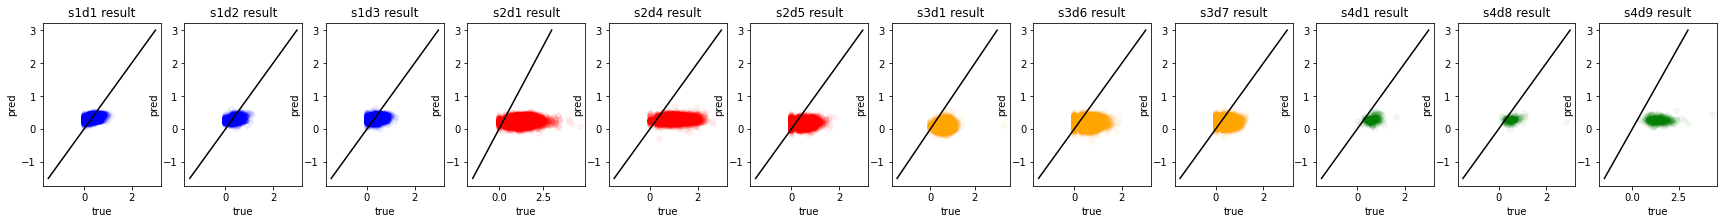

Epoch  4100 s1d1:  0.164469 s1d2:  0.17034511 s1d3:  0.19020079 s2d1: 1.0877775 s2d4: 0.7985156 s2d5: 0.37684163 s3d1: 0.5122964 s3d6: 0.45480368 s3d7: 0.28454703 s4d1: 0.3743499 s4d8: 0.34408355 s4d9: 1.1612126 test loss: 0.8308043199878093
Epoch  4200 s1d1:  0.16437754 s1d2:  0.17039031 s1d3:  0.19021918 s2d1: 1.0877187 s2d4: 0.79867256 s2d5: 0.37666097 s3d1: 0.5126828 s3d6: 0.4549845 s3d7: 0.28467196 s4d1: 0.37444413 s4d8: 0.34404635 s4d9: 1.1611239 test loss: 0.8307584127412159
Epoch  4300 s1d1:  0.16425751 s1d2:  0.17034712 s1d3:  0.19016038 s2d1: 1.0874653 s2d4: 0.7986099 s2d5: 0.37650093 s3d1: 0.5131738 s3d6: 0.45510307 s3d7: 0.28478587 s4d1: 0.37429926 s4d8: 0.3438772 s4d9: 1.160928 test loss: 0.8305964565010184
Epoch  4400 s1d1:  0.16415764 s1d2:  0.17036593 s1d3:  0.19021176 s2d1: 1.0875167 s2d4: 0.7988836 s2d5: 0.37645343 s3d1: 0.5138183 s3d6: 0.45536053 s3d7: 0.2849668 s4d1: 0.37451774 s4d8: 0.34402576 s4d9: 1.1610422 test loss: 0.8307153344851338
Epoch  4500 s1d1:  0.16405

In [33]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d1, pro_s1d1)

Epoch  0 s1d1:  0.2684415 s1d2:  0.26251823 s1d3:  0.2814901 s2d1: 1.2577478 s2d4: 0.95535886 s2d5: 0.52731246 s3d1: 0.59420884 s3d6: 0.5917247 s3d7: 0.40493223 s4d1: 0.47859913 s4d8: 0.44016927 s4d9: 1.283749 test loss: 0.9343705786804543


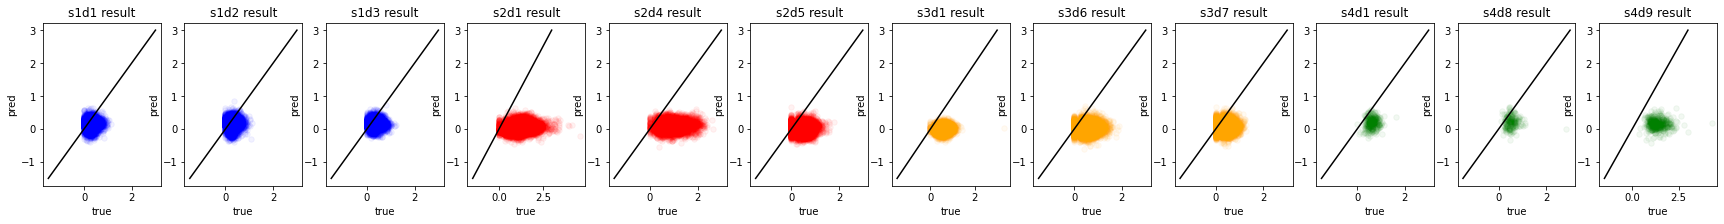

Epoch  100 s1d1:  0.19303611 s1d2:  0.17636518 s1d3:  0.21186537 s2d1: 1.1901929 s2d4: 0.8434275 s2d5: 0.44304788 s3d1: 0.67217195 s3d6: 0.51718134 s3d7: 0.32017827 s4d1: 0.37385887 s4d8: 0.3372474 s4d9: 1.1790599 test loss: 0.8416176349524291
Epoch  200 s1d1:  0.18778756 s1d2:  0.17104901 s1d3:  0.2040491 s2d1: 1.1704199 s2d4: 0.82881147 s2d5: 0.4262863 s3d1: 0.6770132 s3d6: 0.4969718 s3d7: 0.30836588 s4d1: 0.36252373 s4d8: 0.3285673 s4d9: 1.1620718 test loss: 0.8283000934942214
Epoch  300 s1d1:  0.1846335 s1d2:  0.16832682 s1d3:  0.2000092 s2d1: 1.1570487 s2d4: 0.82051766 s2d5: 0.41541407 s3d1: 0.6689062 s3d6: 0.48532397 s3d7: 0.30154392 s4d1: 0.35796404 s4d8: 0.32610804 s4d9: 1.1549095 test loss: 0.8228203976214477
Epoch  400 s1d1:  0.18246517 s1d2:  0.16656679 s1d3:  0.19737068 s2d1: 1.1474003 s2d4: 0.8150673 s2d5: 0.40709952 s3d1: 0.6593653 s3d6: 0.4770108 s3d7: 0.2967684 s4d1: 0.35561618 s4d8: 0.32460284 s4d9: 1.1510731 test loss: 0.8198844252489671
Epoch  500 s1d1:  0.18092021 s

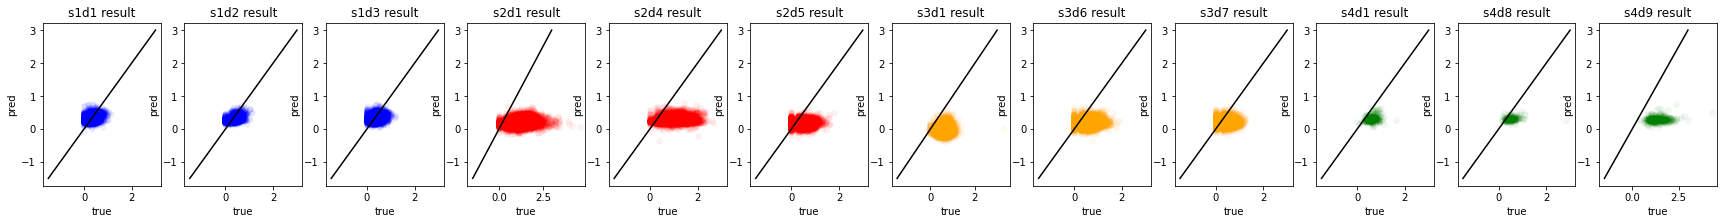

Epoch  1100 s1d1:  0.17749487 s1d2:  0.16238062 s1d3:  0.1902501 s2d1: 1.1134933 s2d4: 0.7989742 s2d5: 0.38082463 s3d1: 0.6186761 s3d6: 0.4499742 s3d7: 0.2837245 s4d1: 0.3499073 s4d8: 0.32179034 s4d9: 1.1423886 test loss: 0.813232255233065
Epoch  1200 s1d1:  0.17729978 s1d2:  0.16213773 s1d3:  0.18983938 s2d1: 1.1106324 s2d4: 0.79776275 s2d5: 0.37854615 s3d1: 0.61456937 s3d6: 0.4478695 s3d7: 0.2826797 s4d1: 0.3493298 s4d8: 0.32152706 s4d9: 1.141715 test loss: 0.8126934504928839
Epoch  1300 s1d1:  0.17706706 s1d2:  0.1619291 s1d3:  0.1895013 s2d1: 1.1082594 s2d4: 0.79714125 s2d5: 0.3765838 s3d1: 0.6104934 s3d6: 0.44632152 s3d7: 0.2818949 s4d1: 0.34919247 s4d8: 0.3215689 s4d9: 1.1415162 test loss: 0.8125489268335238
Epoch  1400 s1d1:  0.17696694 s1d2:  0.16173244 s1d3:  0.18927361 s2d1: 1.1060845 s2d4: 0.7964641 s2d5: 0.37480786 s3d1: 0.6063176 s3d6: 0.44512823 s3d7: 0.28122023 s4d1: 0.34905398 s4d8: 0.3215457 s4d9: 1.1414368 test loss: 0.8124759686840897
Epoch  1500 s1d1:  0.17695098 s1

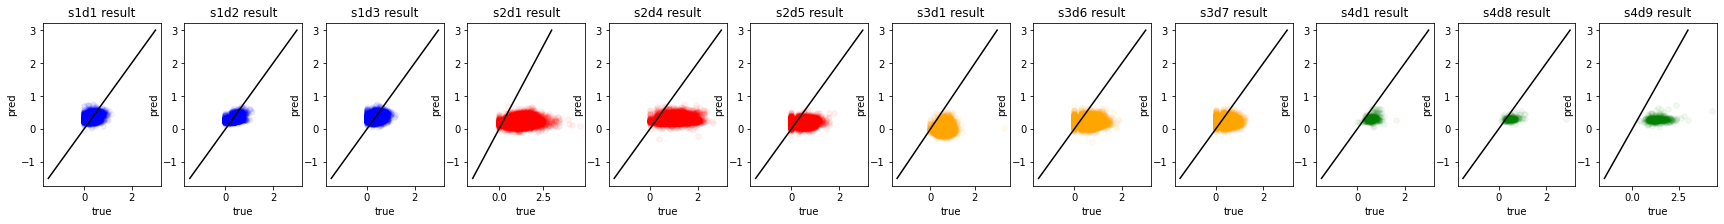

Epoch  2100 s1d1:  0.1768565 s1d2:  0.1606153 s1d3:  0.18848062 s2d1: 1.095355 s2d4: 0.7935566 s2d5: 0.36666515 s3d1: 0.58677876 s3d6: 0.44001722 s3d7: 0.2786053 s4d1: 0.34803373 s4d8: 0.32170215 s4d9: 1.1403639 test loss: 0.8116506754056201
Epoch  2200 s1d1:  0.17688903 s1d2:  0.16047944 s1d3:  0.18846513 s2d1: 1.0942978 s2d4: 0.79344964 s2d5: 0.36591384 s3d1: 0.5845081 s3d6: 0.43970263 s3d7: 0.2784573 s4d1: 0.34825164 s4d8: 0.32199246 s4d9: 1.1405022 test loss: 0.8117948665627092
Epoch  2300 s1d1:  0.17691477 s1d2:  0.16034502 s1d3:  0.18842517 s2d1: 1.0931925 s2d4: 0.79325134 s2d5: 0.36512172 s3d1: 0.5823877 s3d6: 0.43936765 s3d7: 0.27830738 s4d1: 0.34821597 s4d8: 0.32200164 s4d9: 1.1404794 test loss: 0.8117758495029875
Epoch  2400 s1d1:  0.17689358 s1d2:  0.16021366 s1d3:  0.18838161 s2d1: 1.0922288 s2d4: 0.7932442 s2d5: 0.36447674 s3d1: 0.5806845 s3d6: 0.43915296 s3d7: 0.27823278 s4d1: 0.34827808 s4d8: 0.32206684 s4d9: 1.1405398 test loss: 0.8118289938778749
Epoch  2500 s1d1:  0.1

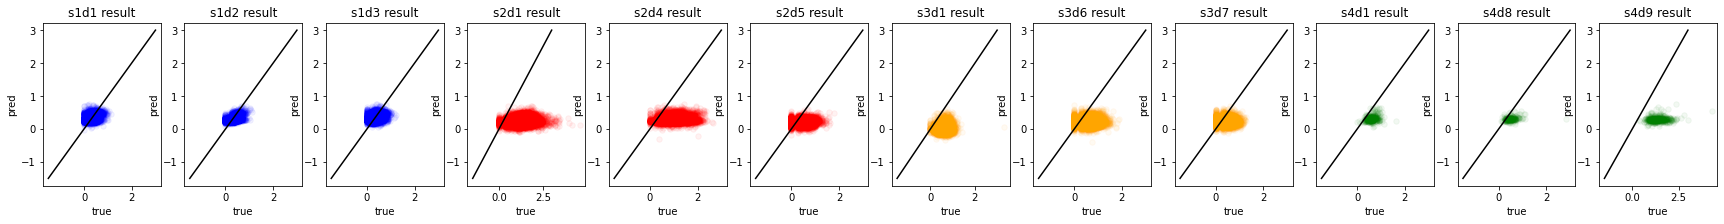

Epoch  3100 s1d1:  0.17734982 s1d2:  0.15931955 s1d3:  0.18842416 s2d1: 1.0863078 s2d4: 0.7923165 s2d5: 0.36096013 s3d1: 0.57182467 s3d6: 0.43800372 s3d7: 0.27772903 s4d1: 0.34756944 s4d8: 0.32165584 s4d9: 1.1403869 test loss: 0.8115952551057268
Epoch  3200 s1d1:  0.17744705 s1d2:  0.15919097 s1d3:  0.18846945 s2d1: 1.0856247 s2d4: 0.79228705 s2d5: 0.36059695 s3d1: 0.57080436 s3d6: 0.43795606 s3d7: 0.27773464 s4d1: 0.34758002 s4d8: 0.32164848 s4d9: 1.1404375 test loss: 0.8116287604382847
Epoch  3300 s1d1:  0.17743075 s1d2:  0.15907153 s1d3:  0.18844359 s2d1: 1.08496 s2d4: 0.7923517 s2d5: 0.36016756 s3d1: 0.5697055 s3d6: 0.4378387 s3d7: 0.27770877 s4d1: 0.34750542 s4d8: 0.3215209 s4d9: 1.1403732 test loss: 0.8115661988084103
Epoch  3400 s1d1:  0.17756222 s1d2:  0.158945 s1d3:  0.18851037 s2d1: 1.0842382 s2d4: 0.79226524 s2d5: 0.3597452 s3d1: 0.5683498 s3d6: 0.43767878 s3d7: 0.27765286 s4d1: 0.34741983 s4d8: 0.32145748 s4d9: 1.140382 test loss: 0.8115544227119923
Epoch  3500 s1d1:  0.177

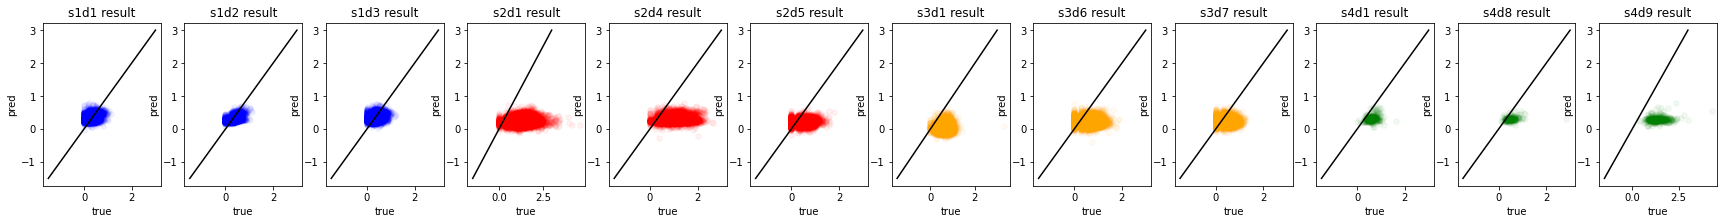

Epoch  4100 s1d1:  0.1781552 s1d2:  0.1581043 s1d3:  0.18887043 s2d1: 1.0806901 s2d4: 0.79251575 s2d5: 0.35789046 s3d1: 0.56300795 s3d6: 0.43725452 s3d7: 0.2775582 s4d1: 0.34741688 s4d8: 0.32147744 s4d9: 1.1407589 test loss: 0.8117986934991358
Epoch  4200 s1d1:  0.17822932 s1d2:  0.15798318 s1d3:  0.18889423 s2d1: 1.0800866 s2d4: 0.79253 s2d5: 0.3576848 s3d1: 0.56227654 s3d6: 0.43722874 s3d7: 0.27757037 s4d1: 0.3473815 s4d8: 0.32145518 s4d9: 1.1407734 test loss: 0.8118011812434166
Epoch  4300 s1d1:  0.17829445 s1d2:  0.15786317 s1d3:  0.18895721 s2d1: 1.079597 s2d4: 0.7926991 s2d5: 0.35746235 s3d1: 0.56134236 s3d6: 0.4372575 s3d7: 0.27759287 s4d1: 0.34743592 s4d8: 0.32154366 s4d9: 1.1410127 test loss: 0.8119705462038931
Epoch  4400 s1d1:  0.17840375 s1d2:  0.15774395 s1d3:  0.18903998 s2d1: 1.0791345 s2d4: 0.7927485 s2d5: 0.3572751 s3d1: 0.5608622 s3d6: 0.43724906 s3d7: 0.2775943 s4d1: 0.34747672 s4d8: 0.32165092 s4d9: 1.1412686 test loss: 0.8121502509479204
Epoch  4500 s1d1:  0.178490

In [34]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d2, pro_s1d2)

Epoch  0 s1d1:  0.2686225 s1d2:  0.26342186 s1d3:  0.28098884 s2d1: 1.2573336 s2d4: 0.9554461 s2d5: 0.5279864 s3d1: 0.593764 s3d6: 0.5918753 s3d7: 0.40587872 s4d1: 0.47868308 s4d8: 0.44076636 s4d9: 1.2834632 test loss: 0.9342630098522667


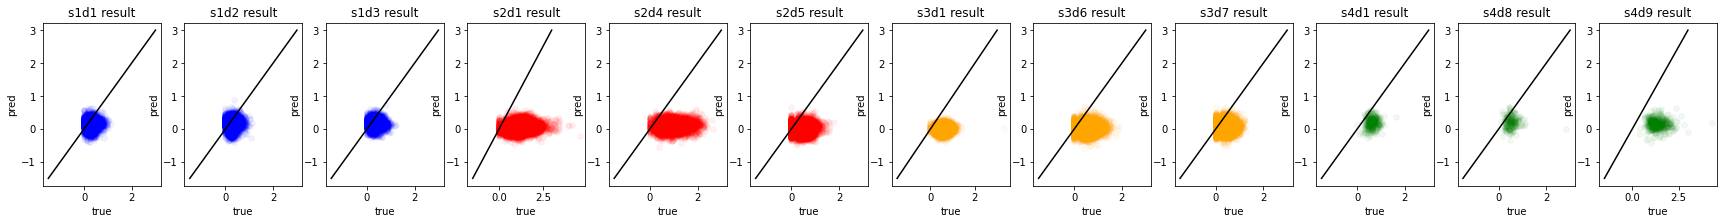

Epoch  100 s1d1:  0.19483252 s1d2:  0.20022455 s1d3:  0.19645411 s2d1: 1.1503141 s2d4: 0.7889678 s2d5: 0.43074095 s3d1: 0.5735096 s3d6: 0.48780516 s3d7: 0.30414513 s4d1: 0.31991372 s4d8: 0.2968504 s4d9: 1.1110795 test loss: 0.7868026491534144
Epoch  200 s1d1:  0.18986143 s1d2:  0.18983558 s1d3:  0.19032185 s2d1: 1.1275053 s2d4: 0.77929157 s2d5: 0.41394717 s3d1: 0.56437826 s3d6: 0.4680135 s3d7: 0.29543987 s4d1: 0.31461915 s4d8: 0.29061347 s4d9: 1.0993295 test loss: 0.7779823933090961
Epoch  300 s1d1:  0.18629892 s1d2:  0.18415631 s1d3:  0.18708912 s2d1: 1.1128938 s2d4: 0.77558017 s2d5: 0.40290263 s3d1: 0.55407315 s3d6: 0.45566544 s3d7: 0.29002 s4d1: 0.3153348 s4d8: 0.28914103 s4d9: 1.0968374 test loss: 0.7763493790221493
Epoch  400 s1d1:  0.1841171 s1d2:  0.18079177 s1d3:  0.18494813 s2d1: 1.1017189 s2d4: 0.77293664 s2d5: 0.39382398 s3d1: 0.5415593 s3d6: 0.44620457 s3d7: 0.2854774 s4d1: 0.316597 s4d8: 0.2889224 s4d9: 1.0960724 test loss: 0.776008136557215
Epoch  500 s1d1:  0.18257208 s1

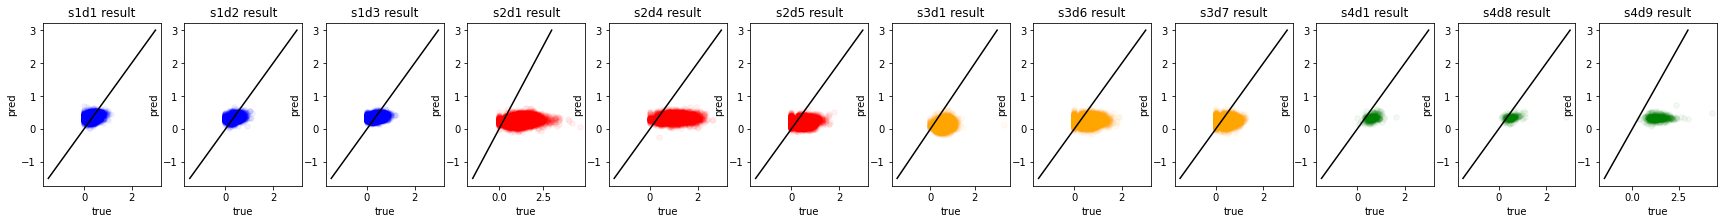

Epoch  1100 s1d1:  0.17867608 s1d2:  0.17231898 s1d3:  0.17945457 s2d1: 1.0614618 s2d4: 0.76822 s2d5: 0.36386004 s3d1: 0.47647128 s3d6: 0.4175672 s3d7: 0.27242014 s4d1: 0.32450423 s4d8: 0.29614243 s4d9: 1.0998058 test loss: 0.7800763645639359
Epoch  1200 s1d1:  0.17848186 s1d2:  0.17189333 s1d3:  0.17909573 s2d1: 1.0583843 s2d4: 0.7677845 s2d5: 0.3616504 s3d1: 0.47107503 s3d6: 0.41570944 s3d7: 0.2716759 s4d1: 0.32477388 s4d8: 0.2966956 s4d9: 1.1000445 test loss: 0.7803117765620738
Epoch  1300 s1d1:  0.17828035 s1d2:  0.17148328 s1d3:  0.17880829 s2d1: 1.0559257 s2d4: 0.7675919 s2d5: 0.35997054 s3d1: 0.4669555 s3d6: 0.41420606 s3d7: 0.2711173 s4d1: 0.32506037 s4d8: 0.29738316 s4d9: 1.1004922 test loss: 0.7806954855007334
Epoch  1400 s1d1:  0.17824131 s1d2:  0.17121269 s1d3:  0.17854834 s2d1: 1.0536913 s2d4: 0.7671886 s2d5: 0.35852122 s3d1: 0.463122 s3d6: 0.4129356 s3d7: 0.27069017 s4d1: 0.3251231 s4d8: 0.29776376 s4d9: 1.1005894 test loss: 0.7807971014339798
Epoch  1500 s1d1:  0.1780694

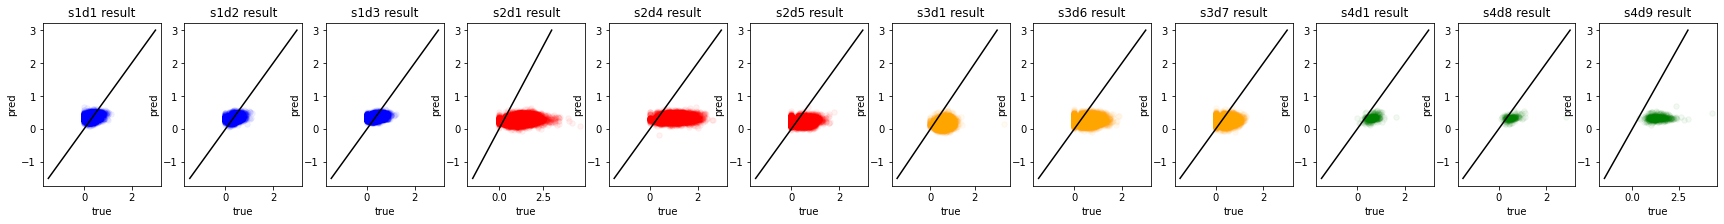

Epoch  2100 s1d1:  0.17772903 s1d2:  0.17024022 s1d3:  0.1773179 s2d1: 1.0469517 s2d4: 0.7665331 s2d5: 0.3539079 s3d1: 0.4512578 s3d6: 0.4094626 s3d7: 0.2698217 s4d1: 0.3268496 s4d8: 0.30030414 s4d9: 1.1018143 test loss: 0.7820312155924588
Epoch  2200 s1d1:  0.17767318 s1d2:  0.17017542 s1d3:  0.17718224 s2d1: 1.0465544 s2d4: 0.7666721 s2d5: 0.35373452 s3d1: 0.4500307 s3d6: 0.40945148 s3d7: 0.26988763 s4d1: 0.3272713 s4d8: 0.3007924 s4d9: 1.1021907 test loss: 0.7823723784039548
Epoch  2300 s1d1:  0.17771885 s1d2:  0.17010924 s1d3:  0.17703259 s2d1: 1.0461984 s2d4: 0.766518 s2d5: 0.3536222 s3d1: 0.44943154 s3d6: 0.40946403 s3d7: 0.2699875 s4d1: 0.32727614 s4d8: 0.30085224 s4d9: 1.1021451 test loss: 0.7823483013712466
Epoch  2400 s1d1:  0.17769675 s1d2:  0.17002727 s1d3:  0.17690042 s2d1: 1.0459874 s2d4: 0.7664388 s2d5: 0.35351485 s3d1: 0.44914895 s3d6: 0.40947515 s3d7: 0.27002057 s4d1: 0.32734305 s4d8: 0.30105162 s4d9: 1.1022931 test loss: 0.7824692287722785
Epoch  2500 s1d1:  0.1776843

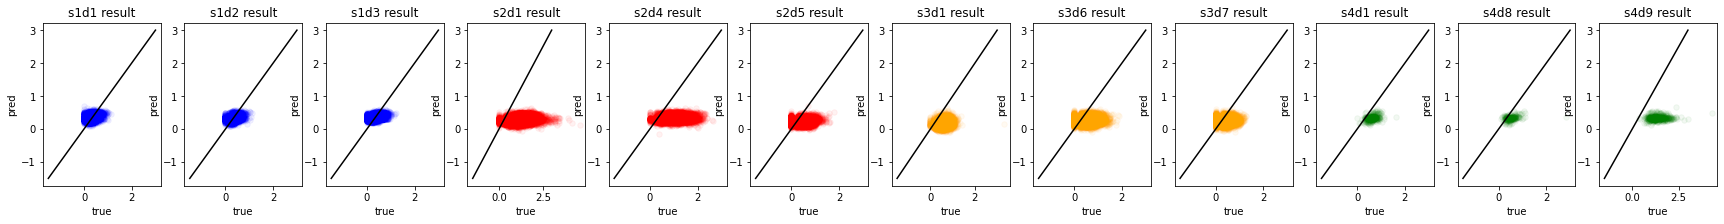

Epoch  3100 s1d1:  0.17786144 s1d2:  0.16981122 s1d3:  0.17602207 s2d1: 1.0449656 s2d4: 0.7660104 s2d5: 0.35319445 s3d1: 0.44804797 s3d6: 0.40985793 s3d7: 0.27054873 s4d1: 0.32726336 s4d8: 0.3013059 s4d9: 1.1021292 test loss: 0.7823723733614935
Epoch  3200 s1d1:  0.17779687 s1d2:  0.1698031 s1d3:  0.17590924 s2d1: 1.0448805 s2d4: 0.76608306 s2d5: 0.35314852 s3d1: 0.44805697 s3d6: 0.4098749 s3d7: 0.27057287 s4d1: 0.32738778 s4d8: 0.30144253 s4d9: 1.1022435 test loss: 0.7824745714350878
Epoch  3300 s1d1:  0.17788546 s1d2:  0.16980442 s1d3:  0.17578252 s2d1: 1.0446143 s2d4: 0.7658053 s2d5: 0.35306478 s3d1: 0.44771832 s3d6: 0.40985972 s3d7: 0.2706075 s4d1: 0.32725644 s4d8: 0.30136755 s4d9: 1.1020331 test loss: 0.7823142152555489
Epoch  3400 s1d1:  0.17790088 s1d2:  0.16980599 s1d3:  0.17566036 s2d1: 1.0446352 s2d4: 0.76573807 s2d5: 0.35306516 s3d1: 0.4477164 s3d6: 0.4099644 s3d7: 0.27066043 s4d1: 0.32730424 s4d8: 0.30139786 s4d9: 1.1019623 test loss: 0.7822775339195206
Epoch  3500 s1d1:  0

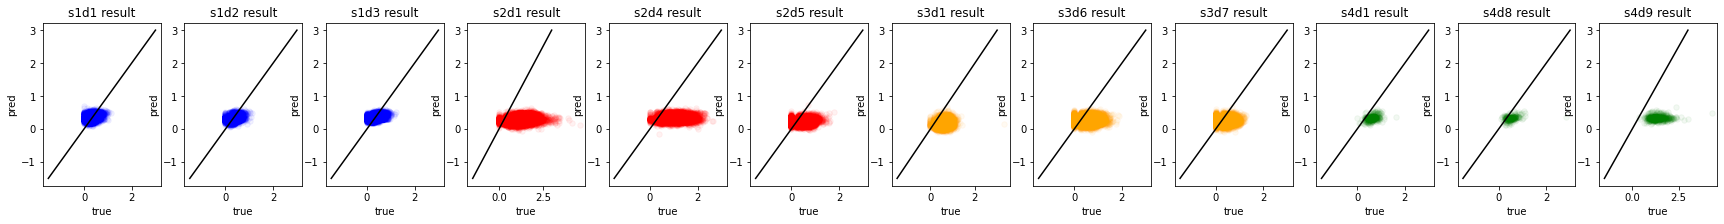

Epoch  4100 s1d1:  0.17815562 s1d2:  0.16988382 s1d3:  0.17482725 s2d1: 1.0449855 s2d4: 0.7657108 s2d5: 0.3540031 s3d1: 0.44983852 s3d6: 0.4109758 s3d7: 0.2715762 s4d1: 0.32732543 s4d8: 0.30157483 s4d9: 1.1015666 test loss: 0.7820387151573337
Epoch  4200 s1d1:  0.17823619 s1d2:  0.1699009 s1d3:  0.17470652 s2d1: 1.0451664 s2d4: 0.7656263 s2d5: 0.35422158 s3d1: 0.4503962 s3d6: 0.41114864 s3d7: 0.27170637 s4d1: 0.3272827 s4d8: 0.3015537 s4d9: 1.1014186 test loss: 0.7819354026871652
Epoch  4300 s1d1:  0.17828108 s1d2:  0.16992849 s1d3:  0.17459017 s2d1: 1.045276 s2d4: 0.7655527 s2d5: 0.3543806 s3d1: 0.4509493 s3d6: 0.41128647 s3d7: 0.2718203 s4d1: 0.32722482 s4d8: 0.3014841 s4d9: 1.1012788 test loss: 0.7818313411288791
Epoch  4400 s1d1:  0.17828861 s1d2:  0.16992146 s1d3:  0.17447653 s2d1: 1.0456165 s2d4: 0.7656107 s2d5: 0.35467404 s3d1: 0.45165756 s3d6: 0.41153595 s3d7: 0.2719787 s4d1: 0.32734683 s4d8: 0.30164787 s4d9: 1.1014031 test loss: 0.7819418813609985
Epoch  4500 s1d1:  0.17836449

In [35]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s1d3, pro_s1d3)

Epoch  0 s1d1:  0.2667902 s1d2:  0.26266515 s1d3:  0.27897495 s2d1: 1.2493093 s2d4: 0.95225203 s2d5: 0.5217743 s3d1: 0.5849811 s3d6: 0.58663875 s3d7: 0.40192172 s4d1: 0.4753972 s4d8: 0.43989524 s4d9: 1.2809758 test loss: 0.9320480798575169


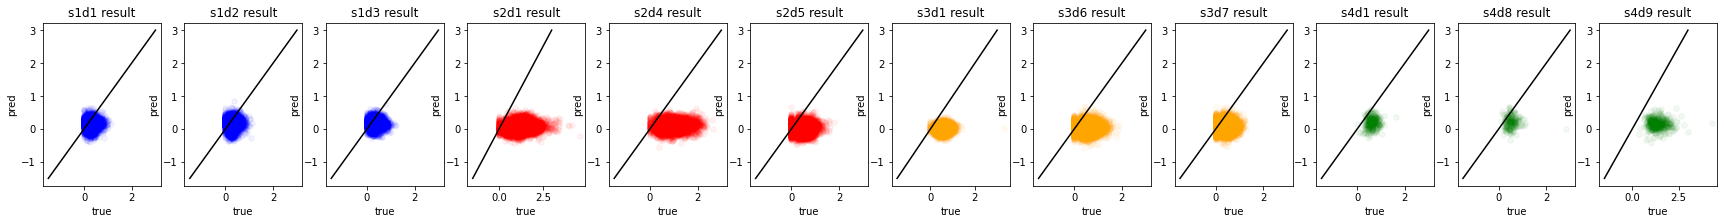

Epoch  100 s1d1:  0.6376548 s1d2:  0.419286 s1d3:  0.59746104 s2d1: 0.51127654 s2d4: 0.5392321 s2d5: 0.71132135 s3d1: 0.66067356 s3d6: 0.5333964 s3d7: 0.5841548 s4d1: 0.4159574 s4d8: 0.3760745 s4d9: 0.7682568 test loss: 0.5983106030914576
Epoch  200 s1d1:  0.6883262 s1d2:  0.46330485 s1d3:  0.6553236 s2d1: 0.50279444 s2d4: 0.51941574 s2d5: 0.7258492 s3d1: 0.64821637 s3d6: 0.5624122 s3d7: 0.61639524 s4d1: 0.45163363 s4d8: 0.40610096 s4d9: 0.69347316 test loss: 0.568331234041923
Epoch  300 s1d1:  0.7151993 s1d2:  0.49205238 s1d3:  0.6883053 s2d1: 0.4986538 s2d4: 0.5070997 s2d5: 0.73183084 s3d1: 0.6380549 s3d6: 0.57841396 s3d7: 0.63535947 s4d1: 0.4684655 s4d8: 0.42715257 s4d9: 0.6509893 test loss: 0.5527992023962564
Epoch  400 s1d1:  0.7383497 s1d2:  0.5175165 s1d3:  0.7142827 s2d1: 0.4960025 s2d4: 0.50038046 s2d5: 0.7339102 s3d1: 0.6301648 s3d6: 0.5900596 s3d7: 0.64933515 s4d1: 0.48196292 s4d8: 0.4461527 s4d9: 0.6213692 test loss: 0.5440660188660825
Epoch  500 s1d1:  0.7590137 s1d2:  0.5

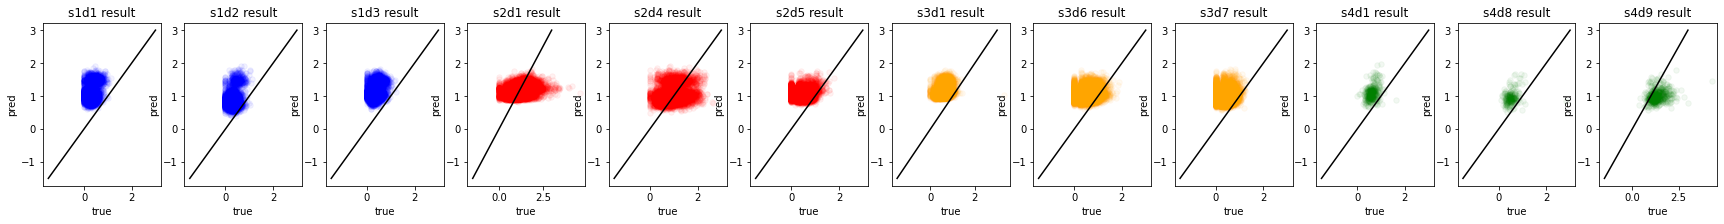

Epoch  1100 s1d1:  0.83810467 s1d2:  0.6401598 s1d3:  0.8275669 s2d1: 0.4885549 s2d4: 0.49279952 s2d5: 0.74674624 s3d1: 0.61721414 s3d6: 0.63106847 s3d7: 0.70256543 s4d1: 0.5392139 s4d8: 0.5270404 s4d9: 0.5289502 test loss: 0.5320080852086866
Epoch  1200 s1d1:  0.8464578 s1d2:  0.65071845 s1d3:  0.8374371 s2d1: 0.48803654 s2d4: 0.49302268 s2d5: 0.7480576 s3d1: 0.61878836 s3d6: 0.633543 s3d7: 0.7061885 s4d1: 0.543538 s4d8: 0.53299 s4d9: 0.5235499 test loss: 0.53225273933082
Epoch  1300 s1d1:  0.8539515 s1d2:  0.66027373 s1d3:  0.84616095 s2d1: 0.4875813 s2d4: 0.4931956 s2d5: 0.74814945 s3d1: 0.6186254 s3d6: 0.63474774 s3d7: 0.7086835 s4d1: 0.5472871 s4d8: 0.53811115 s4d9: 0.51920485 test loss: 0.5326487846780146
Epoch  1400 s1d1:  0.85993487 s1d2:  0.66763383 s1d3:  0.85348755 s2d1: 0.4871491 s2d4: 0.4933161 s2d5: 0.74873954 s3d1: 0.61934674 s3d6: 0.6360397 s3d7: 0.71110636 s4d1: 0.5497379 s4d8: 0.5414098 s4d9: 0.5166654 test loss: 0.533050088488383
Epoch  1500 s1d1:  0.8657256 s1d2:  0

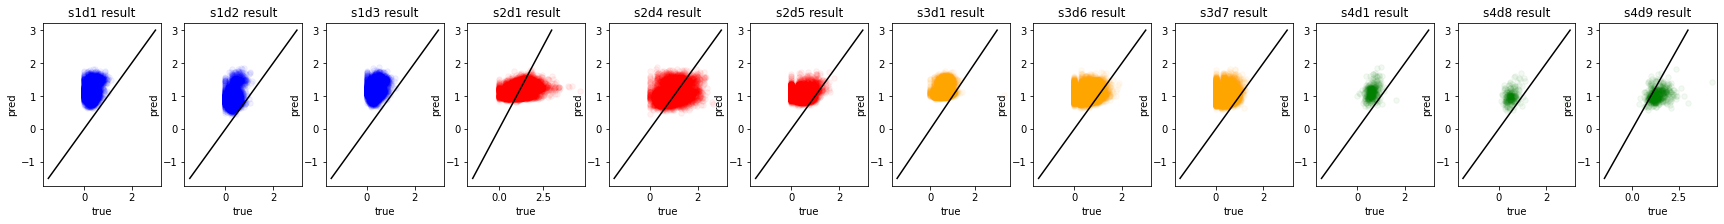

Epoch  2100 s1d1:  0.88831145 s1d2:  0.69373286 s1d3:  0.8877882 s2d1: 0.48453528 s2d4: 0.49387366 s2d5: 0.7490967 s3d1: 0.61715376 s3d6: 0.63548815 s3d7: 0.7203649 s4d1: 0.55760604 s4d8: 0.5485088 s4d9: 0.5174573 test loss: 0.5376150940328598
Epoch  2200 s1d1:  0.8898982 s1d2:  0.69270825 s1d3:  0.8900444 s2d1: 0.4841678 s2d4: 0.49386683 s2d5: 0.7487341 s3d1: 0.6160733 s3d6: 0.63438684 s3d7: 0.72060806 s4d1: 0.5567867 s4d8: 0.54632175 s4d9: 0.5210705 test loss: 0.538471649474048
Epoch  2300 s1d1:  0.8914085 s1d2:  0.6917571 s1d3:  0.892177 s2d1: 0.48378608 s2d4: 0.49391517 s2d5: 0.748116 s3d1: 0.6154673 s3d6: 0.63318926 s3d7: 0.7207745 s4d1: 0.5560829 s4d8: 0.54446006 s4d9: 0.52451384 test loss: 0.5393721377594062
Epoch  2400 s1d1:  0.8928331 s1d2:  0.689546 s1d3:  0.8942007 s2d1: 0.48339507 s2d4: 0.49435365 s2d5: 0.7474397 s3d1: 0.6153418 s3d6: 0.63194656 s3d7: 0.7208794 s4d1: 0.55493724 s4d8: 0.541341 s4d9: 0.52926403 test loss: 0.5404569546597118
Epoch  2500 s1d1:  0.8924388 s1d2: 

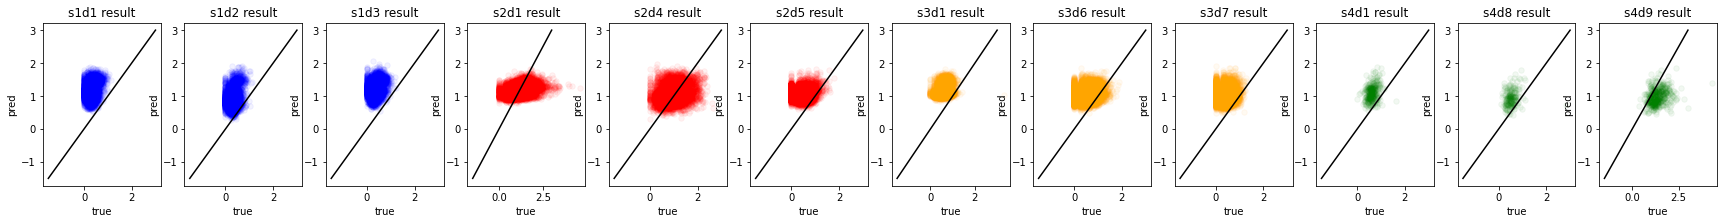

Epoch  3100 s1d1:  0.8926497 s1d2:  0.6687553 s1d3:  0.9020592 s2d1: 0.4805232 s2d4: 0.49495995 s2d5: 0.7424126 s3d1: 0.60962343 s3d6: 0.6207971 s3d7: 0.718128 s4d1: 0.54518634 s4d8: 0.52307314 s4d9: 0.5658944 test loss: 0.5503626964026891
Epoch  3200 s1d1:  0.8923788 s1d2:  0.6646718 s1d3:  0.9031066 s2d1: 0.4800749 s2d4: 0.49556252 s2d5: 0.74179566 s3d1: 0.60935706 s3d6: 0.6192239 s3d7: 0.7174655 s4d1: 0.5433977 s4d8: 0.5196944 s4d9: 0.57272065 test loss: 0.55234682794493
Epoch  3300 s1d1:  0.89083046 s1d2:  0.6603146 s1d3:  0.9031706 s2d1: 0.47964573 s2d4: 0.4954996 s2d5: 0.7410016 s3d1: 0.60808986 s3d6: 0.61744374 s3d7: 0.71661794 s4d1: 0.5413009 s4d8: 0.51647997 s4d9: 0.57941335 test loss: 0.5542356858947364
Epoch  3400 s1d1:  0.88987315 s1d2:  0.65560913 s1d3:  0.90350497 s2d1: 0.4791909 s2d4: 0.49606875 s2d5: 0.7398282 s3d1: 0.60718095 s3d6: 0.61572295 s3d7: 0.7156745 s4d1: 0.5392646 s4d8: 0.51320446 s4d9: 0.5869488 test loss: 0.5565773224556979
Epoch  3500 s1d1:  0.8882304 s1d2

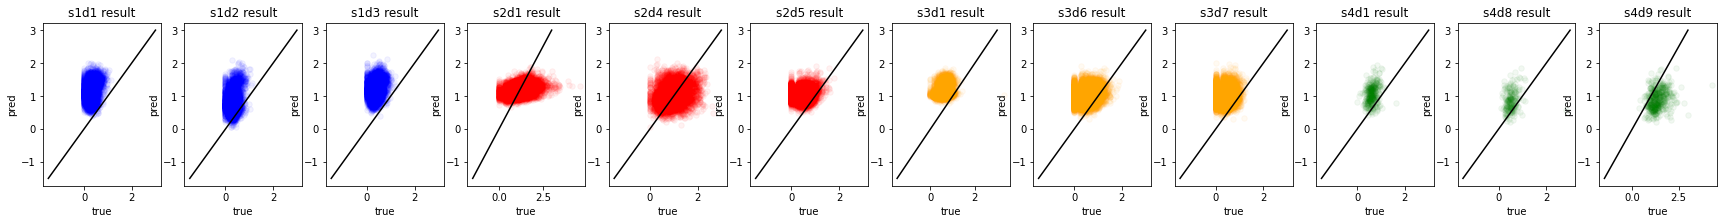

Epoch  4100 s1d1:  0.88115996 s1d2:  0.6251196 s1d3:  0.9041601 s2d1: 0.47587082 s2d4: 0.50153744 s2d5: 0.73325163 s3d1: 0.60221696 s3d6: 0.60475314 s3d7: 0.7091941 s4d1: 0.5298549 s4d8: 0.49767396 s4d9: 0.64245826 test loss: 0.5783531131608943
Epoch  4200 s1d1:  0.8804124 s1d2:  0.6208083 s1d3:  0.9047717 s2d1: 0.47535342 s2d4: 0.502936 s2d5: 0.73258805 s3d1: 0.60152465 s3d6: 0.6035757 s3d7: 0.7082953 s4d1: 0.52910167 s4d8: 0.49615774 s4d9: 0.6511356 test loss: 0.5822939570827739
Epoch  4300 s1d1:  0.878984 s1d2:  0.61649126 s1d3:  0.90462494 s2d1: 0.47484365 s2d4: 0.5043192 s2d5: 0.7312987 s3d1: 0.60005736 s3d6: 0.6021401 s3d7: 0.70728177 s4d1: 0.5277685 s4d8: 0.4943798 s4d9: 0.66059273 test loss: 0.5864512451386078
Epoch  4400 s1d1:  0.87765497 s1d2:  0.61238587 s1d3:  0.90471166 s2d1: 0.47431487 s2d4: 0.5056938 s2d5: 0.7302013 s3d1: 0.5985025 s3d6: 0.600751 s3d7: 0.7063385 s4d1: 0.52633876 s4d8: 0.4929373 s4d9: 0.6703948 test loss: 0.5908596978041037
Epoch  4500 s1d1:  0.87723213 s

In [36]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d1, pro_s2d1)

Epoch  0 s1d1:  0.26887444 s1d2:  0.2625773 s1d3:  0.28198126 s2d1: 1.2553809 s2d4: 0.95568925 s2d5: 0.5232541 s3d1: 0.58986133 s3d6: 0.5895186 s3d7: 0.40264523 s4d1: 0.47860166 s4d8: 0.44078565 s4d9: 1.2846671 test loss: 0.9350101577524491


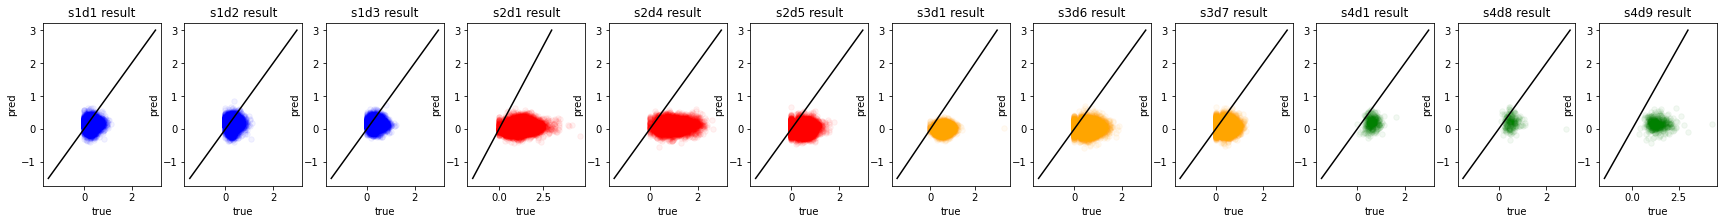

Epoch  100 s1d1:  0.20981501 s1d2:  0.22755876 s1d3:  0.21593969 s2d1: 1.0042483 s2d4: 0.7671878 s2d5: 0.29939717 s3d1: 0.30486527 s3d6: 0.38579506 s3d7: 0.27963382 s4d1: 0.3054879 s4d8: 0.31962478 s4d9: 1.1305312 test loss: 0.7993529815461767
Epoch  200 s1d1:  0.25521266 s1d2:  0.23983319 s1d3:  0.22965735 s2d1: 0.9540156 s2d4: 0.6942778 s2d5: 0.28959742 s3d1: 0.27883613 s3d6: 0.3619927 s3d7: 0.27555585 s4d1: 0.26771057 s4d8: 0.2900788 s4d9: 1.0760193 test loss: 0.7568314295726777
Epoch  300 s1d1:  0.30359843 s1d2:  0.260316 s1d3:  0.26459196 s2d1: 0.9306548 s2d4: 0.6607318 s2d5: 0.28580305 s3d1: 0.27563664 s3d6: 0.352422 s3d7: 0.27720505 s4d1: 0.25879928 s4d8: 0.27981278 s4d9: 1.0396606 test loss: 0.7312372007278921
Epoch  400 s1d1:  0.3289853 s1d2:  0.27246118 s1d3:  0.2844613 s2d1: 0.91868865 s2d4: 0.64415157 s2d5: 0.2837317 s3d1: 0.27451217 s3d6: 0.34783557 s3d7: 0.27839825 s4d1: 0.25645477 s4d8: 0.27663177 s4d9: 1.0182583 test loss: 0.7167438201083204
Epoch  500 s1d1:  0.344413 s

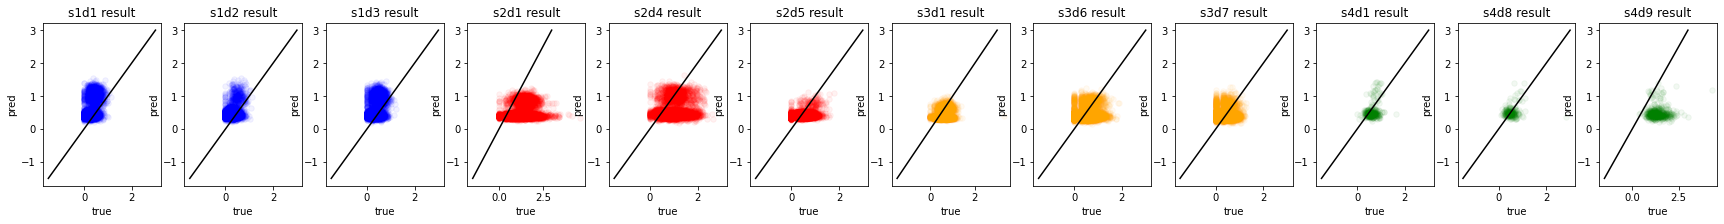

Epoch  1100 s1d1:  0.38760838 s1d2:  0.2988543 s1d3:  0.3355035 s2d1: 0.8880498 s2d4: 0.61332595 s2d5: 0.27886945 s3d1: 0.26273602 s3d6: 0.3402219 s3d7: 0.28151125 s4d1: 0.2580509 s4d8: 0.27219665 s4d9: 0.9777528 test loss: 0.690204497890503
Epoch  1200 s1d1:  0.38979068 s1d2:  0.30001667 s1d3:  0.3377225 s2d1: 0.8865275 s2d4: 0.6118927 s2d5: 0.27860358 s3d1: 0.26144493 s3d6: 0.3396682 s3d7: 0.28152952 s4d1: 0.2575556 s4d8: 0.27165967 s4d9: 0.9761089 test loss: 0.6890299009161297
Epoch  1300 s1d1:  0.39254692 s1d2:  0.3013448 s1d3:  0.34057933 s2d1: 0.88499665 s2d4: 0.61057204 s2d5: 0.27836934 s3d1: 0.2602305 s3d6: 0.33928317 s3d7: 0.28165272 s4d1: 0.25748652 s4d8: 0.27132082 s4d9: 0.97469294 test loss: 0.6880729314466573
Epoch  1400 s1d1:  0.39575154 s1d2:  0.3027152 s1d3:  0.34360403 s2d1: 0.88373923 s2d4: 0.6096442 s2d5: 0.27815795 s3d1: 0.25925016 s3d6: 0.3392258 s3d7: 0.2818539 s4d1: 0.25796375 s4d8: 0.27122357 s4d9: 0.97390664 test loss: 0.6876134941802837
Epoch  1500 s1d1:  0.39

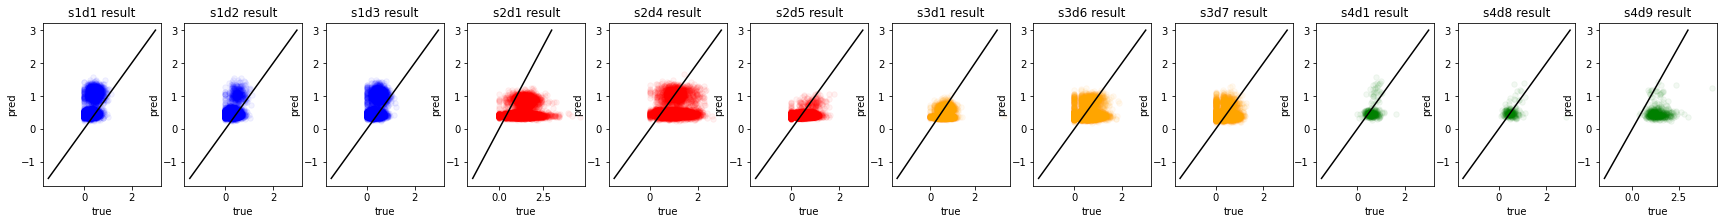

Epoch  2100 s1d1:  0.41345802 s1d2:  0.31064305 s1d3:  0.36050522 s2d1: 0.87789667 s2d4: 0.60607755 s2d5: 0.27700362 s3d1: 0.25544807 s3d6: 0.3395611 s3d7: 0.28264314 s4d1: 0.26092273 s4d8: 0.2709998 s4d9: 0.9701717 test loss: 0.6855415377558556
Epoch  2200 s1d1:  0.4154204 s1d2:  0.31190443 s1d3:  0.36223075 s2d1: 0.87748295 s2d4: 0.6056352 s2d5: 0.27686715 s3d1: 0.25532115 s3d6: 0.33963493 s3d7: 0.28270903 s4d1: 0.26097587 s4d8: 0.2711541 s4d9: 0.9691548 test loss: 0.6849004077734439
Epoch  2300 s1d1:  0.41810253 s1d2:  0.31331372 s1d3:  0.3646246 s2d1: 0.8770104 s2d4: 0.60530627 s2d5: 0.27673325 s3d1: 0.25509137 s3d6: 0.33984762 s3d7: 0.28281155 s4d1: 0.2615792 s4d8: 0.27145264 s4d9: 0.968445 test loss: 0.6845408360914361
Epoch  2400 s1d1:  0.42044684 s1d2:  0.3145224 s1d3:  0.36669523 s2d1: 0.87671334 s2d4: 0.6051606 s2d5: 0.27660108 s3d1: 0.25489688 s3d6: 0.34010324 s3d7: 0.28284243 s4d1: 0.2620398 s4d8: 0.27167696 s4d9: 0.967934 test loss: 0.6842863310894283
Epoch  2500 s1d1:  0.

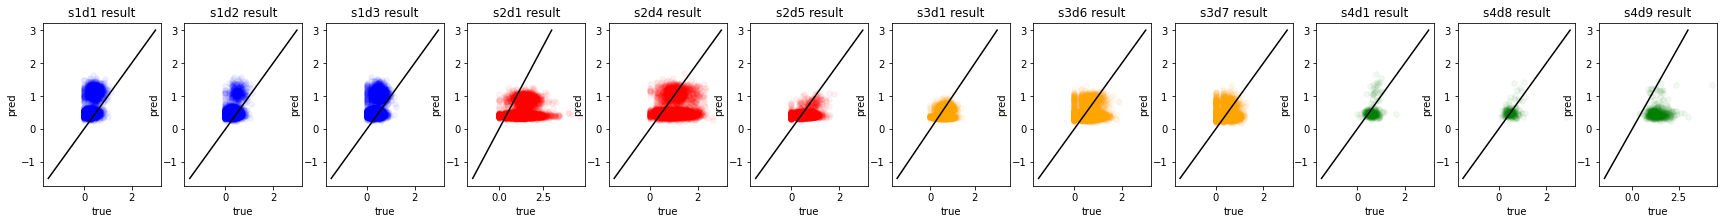

Epoch  3100 s1d1:  0.434574 s1d2:  0.3240646 s1d3:  0.37942106 s2d1: 0.87573665 s2d4: 0.6031555 s2d5: 0.27571216 s3d1: 0.25527838 s3d6: 0.3417089 s3d7: 0.28310525 s4d1: 0.26400828 s4d8: 0.27362362 s4d9: 0.96263456 test loss: 0.6812615996978731
Epoch  3200 s1d1:  0.43652475 s1d2:  0.32547826 s1d3:  0.38120696 s2d1: 0.8758062 s2d4: 0.60300106 s2d5: 0.27558592 s3d1: 0.25566173 s3d6: 0.34202817 s3d7: 0.28311846 s4d1: 0.26434356 s4d8: 0.27393633 s4d9: 0.9619157 test loss: 0.6808648411131414
Epoch  3300 s1d1:  0.4383811 s1d2:  0.32696018 s1d3:  0.382897 s2d1: 0.87581533 s2d4: 0.60272455 s2d5: 0.27546024 s3d1: 0.25581712 s3d6: 0.34226692 s3d7: 0.2831389 s4d1: 0.2644719 s4d8: 0.27422407 s4d9: 0.9610005 test loss: 0.6803120506580395
Epoch  3400 s1d1:  0.44146514 s1d2:  0.32898763 s1d3:  0.38550177 s2d1: 0.8755499 s2d4: 0.60236484 s2d5: 0.2753331 s3d1: 0.2558848 s3d6: 0.3426118 s3d7: 0.2833473 s4d1: 0.26516446 s4d8: 0.27479422 s4d9: 0.9599122 test loss: 0.6797442547736261
Epoch  3500 s1d1:  0.44

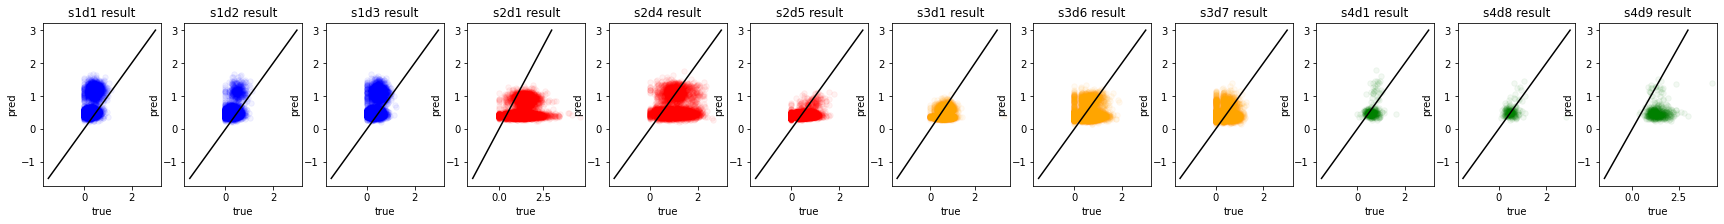

Epoch  4100 s1d1:  0.45593795 s1d2:  0.3409784 s1d3:  0.398398 s2d1: 0.87577397 s2d4: 0.5999983 s2d5: 0.27442107 s3d1: 0.25823212 s3d6: 0.34462076 s3d7: 0.28372654 s4d1: 0.26684225 s4d8: 0.27775598 s4d9: 0.9527365 test loss: 0.67556610338024
Epoch  4200 s1d1:  0.45851412 s1d2:  0.34297398 s1d3:  0.40060008 s2d1: 0.8756438 s2d4: 0.5996266 s2d5: 0.27428386 s3d1: 0.25854275 s3d6: 0.34498146 s3d7: 0.28390786 s4d1: 0.26726934 s4d8: 0.27834156 s4d9: 0.95156616 test loss: 0.6749149560336354
Epoch  4300 s1d1:  0.46021193 s1d2:  0.34445956 s1d3:  0.40203118 s2d1: 0.87590444 s2d4: 0.5993878 s2d5: 0.27415067 s3d1: 0.25895825 s3d6: 0.34531564 s3d7: 0.28384703 s4d1: 0.26742387 s4d8: 0.27883542 s4d9: 0.95060664 test loss: 0.674356714909805
Epoch  4400 s1d1:  0.46254858 s1d2:  0.34652933 s1d3:  0.4040225 s2d1: 0.8758926 s2d4: 0.59890455 s2d5: 0.2740122 s3d1: 0.25920168 s3d6: 0.34558484 s3d7: 0.28393903 s4d1: 0.26765457 s4d8: 0.27940616 s4d9: 0.94917387 test loss: 0.6735093211611434
Epoch  4500 s1d1: 

In [33]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s2d5, pro_s2d5)

Epoch  0 s1d1:  0.26994503 s1d2:  0.26562303 s1d3:  0.28264663 s2d1: 1.2540232 s2d4: 0.9587183 s2d5: 0.52398896 s3d1: 0.57920116 s3d6: 0.59018135 s3d7: 0.40404984 s4d1: 0.4826011 s4d8: 0.44664994 s4d9: 1.2908244 test loss: 0.9401511030878856


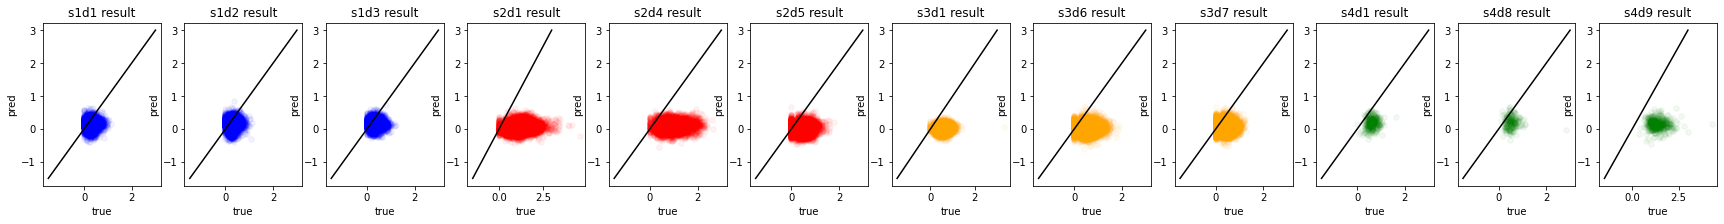

Epoch  100 s1d1:  0.36710992 s1d2:  0.526362 s1d3:  0.35410792 s2d1: 1.0378183 s2d4: 1.0593288 s2d5: 0.3894258 s3d1: 0.20455943 s3d6: 0.49910137 s3d7: 0.33240142 s4d1: 0.6775067 s4d8: 0.79778147 s4d9: 1.603766 test loss: 1.2106342789053612
Epoch  200 s1d1:  0.3504833 s1d2:  0.5101435 s1d3:  0.33589435 s2d1: 1.0159279 s2d4: 1.0363638 s2d5: 0.37355584 s3d1: 0.20026591 s3d6: 0.47733897 s3d7: 0.3142192 s4d1: 0.66060966 s4d8: 0.7820522 s4d9: 1.5842222 test loss: 1.1934577808419913
Epoch  300 s1d1:  0.3361027 s1d2:  0.49358922 s1d3:  0.32060695 s2d1: 0.9990827 s2d4: 1.0168654 s2d5: 0.36180657 s3d1: 0.19804832 s3d6: 0.46087998 s3d7: 0.30234352 s4d1: 0.6444519 s4d8: 0.76532894 s4d9: 1.5648615 test loss: 1.176417228550223
Epoch  400 s1d1:  0.3237961 s1d2:  0.47801554 s1d3:  0.30760553 s2d1: 0.9858155 s2d4: 1.0002252 s2d5: 0.3529412 s3d1: 0.19665365 s3d6: 0.4479817 s3d7: 0.2943459 s4d1: 0.62954235 s4d8: 0.74928474 s4d9: 1.5467441 test loss: 1.160477140880906
Epoch  500 s1d1:  0.31332248 s1d2:  0

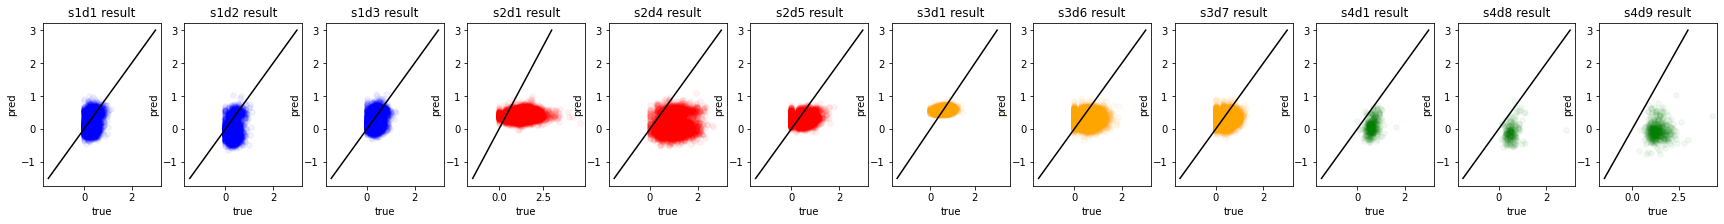

Epoch  1100 s1d1:  0.28383142 s1d2:  0.4196682 s1d3:  0.26522487 s2d1: 0.93103486 s2d4: 0.935491 s2d5: 0.32106772 s3d1: 0.19314888 s3d6: 0.39970517 s3d7: 0.27359414 s4d1: 0.5697579 s4d8: 0.6868706 s4d9: 1.4759376 test loss: 1.0981652828577904
Epoch  1200 s1d1:  0.28053138 s1d2:  0.4133928 s1d3:  0.26203936 s2d1: 0.9260862 s2d4: 0.92876494 s2d5: 0.31867412 s3d1: 0.19294883 s3d6: 0.39558443 s3d7: 0.2725738 s4d1: 0.5632957 s4d8: 0.67968935 s4d9: 1.4683181 test loss: 1.091417912671438
Epoch  1300 s1d1:  0.27710217 s1d2:  0.4066471 s1d3:  0.2588245 s2d1: 0.9217649 s2d4: 0.9221433 s2d5: 0.31649628 s3d1: 0.19279055 s3d6: 0.3917556 s3d7: 0.27169394 s4d1: 0.5569784 s4d8: 0.67237145 s4d9: 1.4608519 test loss: 1.0847778142148772
Epoch  1400 s1d1:  0.27442193 s1d2:  0.40084362 s1d3:  0.25632554 s2d1: 0.9178218 s2d4: 0.9161747 s2d5: 0.31458881 s3d1: 0.19265519 s3d6: 0.38837758 s3d7: 0.2710469 s4d1: 0.55139154 s4d8: 0.66592854 s4d9: 1.4542694 test loss: 1.078926368984331
Epoch  1500 s1d1:  0.2721817

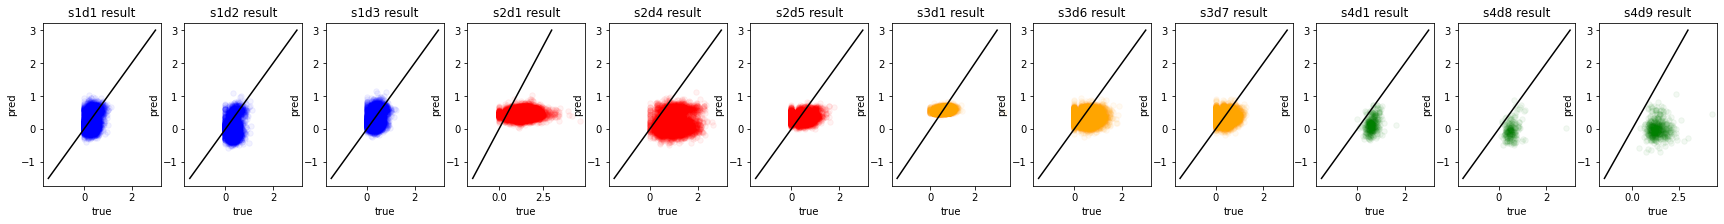

Epoch  2100 s1d1:  0.26552588 s1d2:  0.37659478 s1d3:  0.24869387 s2d1: 0.8993283 s2d4: 0.8891888 s2d5: 0.30694544 s3d1: 0.1921105 s3d6: 0.37366742 s3d7: 0.27015272 s4d1: 0.5265499 s4d8: 0.63758963 s4d9: 1.4247658 test loss: 1.0528549092210262
Epoch  2200 s1d1:  0.26455557 s1d2:  0.3733754 s1d3:  0.24804884 s2d1: 0.89761513 s2d4: 0.8859909 s2d5: 0.30628446 s3d1: 0.19206248 s3d6: 0.3722569 s3d7: 0.27021495 s4d1: 0.52372205 s4d8: 0.6341227 s4d9: 1.4213221 test loss: 1.0498095624659702
Epoch  2300 s1d1:  0.26355147 s1d2:  0.37036562 s1d3:  0.24737646 s2d1: 0.8963677 s2d4: 0.88325703 s2d5: 0.3057684 s3d1: 0.19202527 s3d6: 0.37103793 s3d7: 0.2702453 s4d1: 0.5210116 s4d8: 0.63062024 s4d9: 1.417958 test loss: 1.0468300297600777
Epoch  2400 s1d1:  0.26278043 s1d2:  0.3673112 s1d3:  0.24703065 s2d1: 0.89507246 s2d4: 0.8802612 s2d5: 0.30527008 s3d1: 0.19198325 s3d6: 0.36993328 s3d7: 0.2703293 s4d1: 0.518214 s4d8: 0.6270386 s4d9: 1.4144568 test loss: 1.0437422220431412
Epoch  2500 s1d1:  0.262092

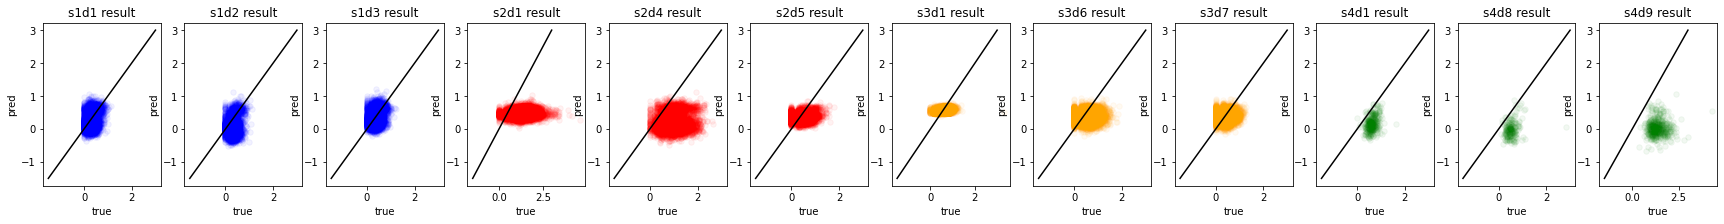

Epoch  3100 s1d1:  0.26054272 s1d2:  0.35546517 s1d3:  0.24678339 s2d1: 0.88886976 s2d4: 0.8685658 s2d5: 0.30304682 s3d1: 0.19175601 s3d6: 0.36492103 s3d7: 0.27123606 s4d1: 0.5070029 s4d8: 0.61310774 s4d9: 1.4011598 test loss: 1.031890519774631
Epoch  3200 s1d1:  0.26059046 s1d2:  0.35492918 s1d3:  0.24699217 s2d1: 0.8882799 s2d4: 0.86797583 s2d5: 0.30287722 s3d1: 0.19173135 s3d6: 0.3645055 s3d7: 0.27137616 s4d1: 0.5063941 s4d8: 0.6125048 s4d9: 1.4006073 test loss: 1.0313721716934137
Epoch  3300 s1d1:  0.26070517 s1d2:  0.35429314 s1d3:  0.2472406 s2d1: 0.8876462 s2d4: 0.86711454 s2d5: 0.30269146 s3d1: 0.19170326 s3d6: 0.3640774 s3d7: 0.2715322 s4d1: 0.5055164 s4d8: 0.6115013 s4d9: 1.3996599 test loss: 1.0305143777001848
Epoch  3400 s1d1:  0.26069605 s1d2:  0.35363293 s1d3:  0.24738653 s2d1: 0.8871639 s2d4: 0.8664823 s2d5: 0.3025357 s3d1: 0.19168217 s3d6: 0.36370575 s3d7: 0.27164915 s4d1: 0.50481915 s4d8: 0.6107437 s4d9: 1.39899 test loss: 1.0298895264465846
Epoch  3500 s1d1:  0.260729

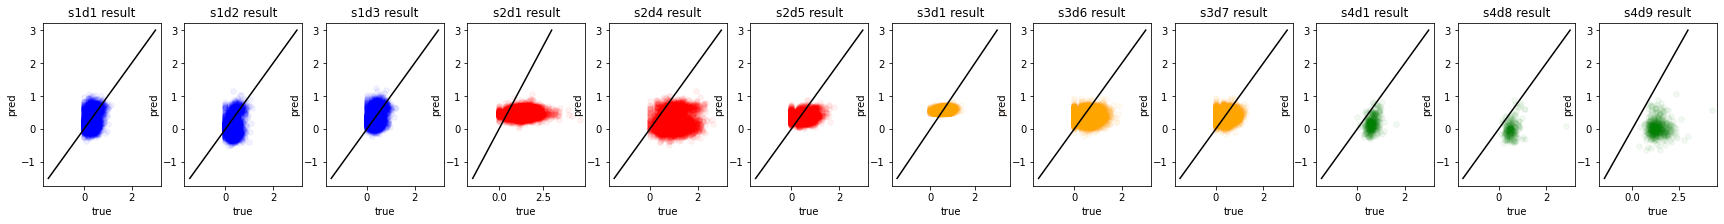

Epoch  4100 s1d1:  0.26058286 s1d2:  0.3484541 s1d3:  0.24828812 s2d1: 0.88414073 s2d4: 0.8617097 s2d5: 0.30170345 s3d1: 0.19153032 s3d6: 0.3614582 s3d7: 0.27236643 s4d1: 0.49932262 s4d8: 0.60440624 s4d9: 1.3932028 test loss: 1.0246061860215607
Epoch  4200 s1d1:  0.26060176 s1d2:  0.34785056 s1d3:  0.24844794 s2d1: 0.8835913 s2d4: 0.8610427 s2d5: 0.30158716 s3d1: 0.1915057 s3d6: 0.36112377 s3d7: 0.27248618 s4d1: 0.49852705 s4d8: 0.6035388 s4d9: 1.3923709 test loss: 1.0238516753543483
Epoch  4300 s1d1:  0.26069126 s1d2:  0.3475068 s1d3:  0.24865976 s2d1: 0.8833311 s2d4: 0.8607528 s2d5: 0.30152923 s3d1: 0.19148402 s3d6: 0.36095545 s3d7: 0.27257216 s4d1: 0.49815008 s4d8: 0.6030752 s4d9: 1.3920227 test loss: 1.0235164658316094
Epoch  4400 s1d1:  0.26066294 s1d2:  0.34708205 s1d3:  0.24873504 s2d1: 0.883001 s2d4: 0.86032367 s2d5: 0.3014511 s3d1: 0.19146386 s3d6: 0.36072668 s3d7: 0.2726641 s4d1: 0.49765936 s4d8: 0.6025228 s4d9: 1.3915745 test loss: 1.0230895154062498
Epoch  4500 s1d1:  0.260

In [34]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d1, pro_s3d1)

Epoch  0 s1d1:  0.26850328 s1d2:  0.26260462 s1d3:  0.28108716 s2d1: 1.2553366 s2d4: 0.95403004 s2d5: 0.5248597 s3d1: 0.5913354 s3d6: 0.5887575 s3d7: 0.4030816 s4d1: 0.4771552 s4d8: 0.43914512 s4d9: 1.281741 test loss: 0.9327574919371243


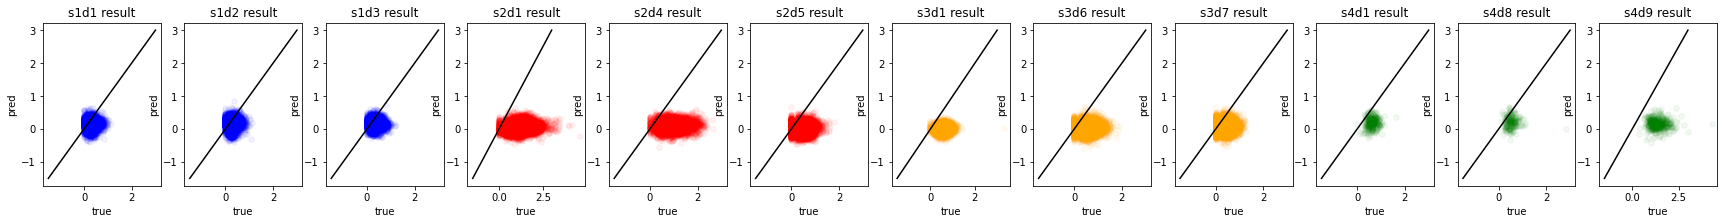

Epoch  100 s1d1:  0.30516872 s1d2:  0.30875826 s1d3:  0.2820909 s2d1: 0.89375454 s2d4: 0.6207034 s2d5: 0.32979444 s3d1: 0.24805132 s3d6: 0.31459925 s3d7: 0.3038026 s4d1: 0.21428935 s4d8: 0.300705 s4d9: 0.9105331 test loss: 0.6438930445427546
Epoch  200 s1d1:  0.30264977 s1d2:  0.2999993 s1d3:  0.28231043 s2d1: 0.883599 s2d4: 0.6152011 s2d5: 0.32652578 s3d1: 0.2305984 s3d6: 0.30822292 s3d7: 0.3037318 s4d1: 0.20807 s4d8: 0.28633934 s4d9: 0.91863865 test loss: 0.6471325941593525
Epoch  300 s1d1:  0.30011845 s1d2:  0.29547483 s1d3:  0.28234595 s2d1: 0.8762967 s2d4: 0.61248213 s2d5: 0.32453752 s3d1: 0.22227152 s3d6: 0.3047815 s3d7: 0.30389008 s4d1: 0.20456715 s4d8: 0.27903706 s4d9: 0.9231225 test loss: 0.6490252277936187
Epoch  400 s1d1:  0.2997462 s1d2:  0.29511532 s1d3:  0.28329098 s2d1: 0.8709547 s2d4: 0.60953426 s2d5: 0.32334408 s3d1: 0.2172784 s3d6: 0.30258325 s3d7: 0.30483165 s4d1: 0.20236056 s4d8: 0.2752366 s4d9: 0.9249123 test loss: 0.6496275458142858
Epoch  500 s1d1:  0.30019698 s1

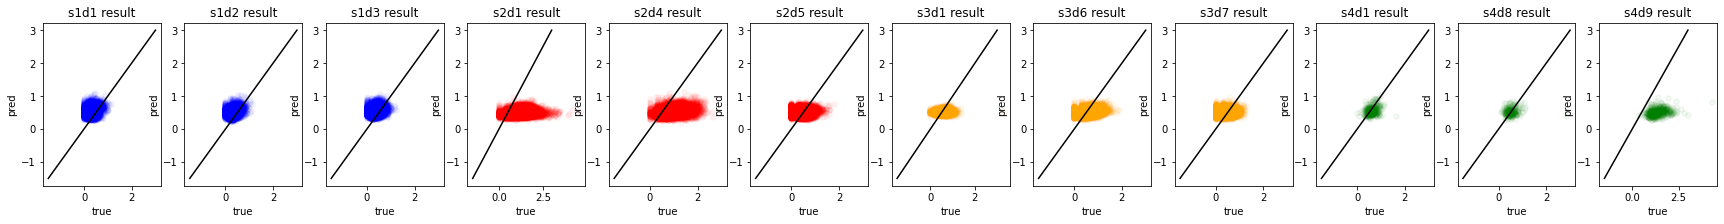

Epoch  1100 s1d1:  0.3010313 s1d2:  0.2927635 s1d3:  0.28952828 s2d1: 0.8511178 s2d4: 0.60413975 s2d5: 0.32135203 s3d1: 0.20657541 s3d6: 0.29721507 s3d7: 0.306938 s4d1: 0.19947523 s4d8: 0.26452994 s4d9: 0.9347643 test loss: 0.6548603330861711
Epoch  1200 s1d1:  0.30156493 s1d2:  0.29296204 s1d3:  0.2904532 s2d1: 0.84938914 s2d4: 0.60384285 s2d5: 0.3216777 s3d1: 0.2059822 s3d6: 0.2968822 s3d7: 0.30742985 s4d1: 0.1995842 s4d8: 0.26419932 s4d9: 0.9355142 test loss: 0.6553351365219553
Epoch  1300 s1d1:  0.3018032 s1d2:  0.29301992 s1d3:  0.29113498 s2d1: 0.84814626 s2d4: 0.60383403 s2d5: 0.32184282 s3d1: 0.20553032 s3d6: 0.29659417 s3d7: 0.3076024 s4d1: 0.19974521 s4d8: 0.26400918 s4d9: 0.9365945 test loss: 0.6560435205118489
Epoch  1400 s1d1:  0.30183515 s1d2:  0.2924815 s1d3:  0.29153997 s2d1: 0.8468403 s2d4: 0.6040635 s2d5: 0.32204846 s3d1: 0.20506555 s3d6: 0.29633033 s3d7: 0.30787897 s4d1: 0.19998686 s4d8: 0.26370066 s4d9: 0.9382163 test loss: 0.6571052453980867
Epoch  1500 s1d1:  0.30

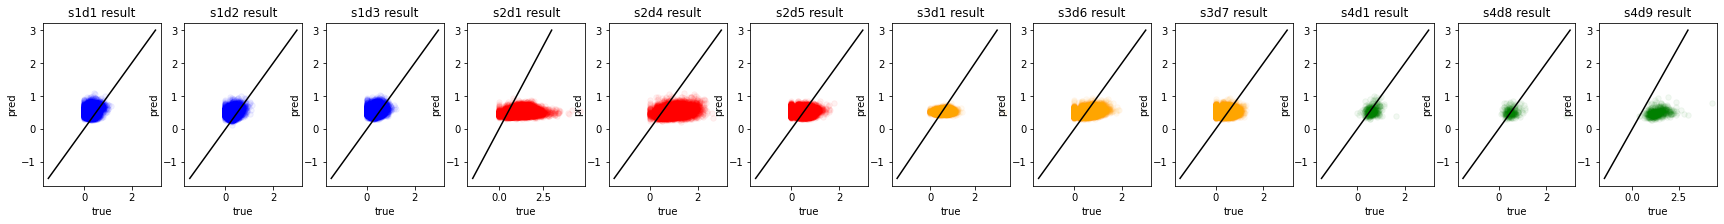

Epoch  2100 s1d1:  0.3040051 s1d2:  0.29371512 s1d3:  0.29570502 s2d1: 0.84100926 s2d4: 0.6047604 s2d5: 0.32442528 s3d1: 0.20313844 s3d6: 0.29482654 s3d7: 0.3104134 s4d1: 0.2022185 s4d8: 0.26430973 s4d9: 0.94538814 test loss: 0.6620832504081005
Epoch  2200 s1d1:  0.30446637 s1d2:  0.29389808 s1d3:  0.29641223 s2d1: 0.8402989 s2d4: 0.60475737 s2d5: 0.32480386 s3d1: 0.20292315 s3d6: 0.29464236 s3d7: 0.31073037 s4d1: 0.20252864 s4d8: 0.264434 s4d9: 0.9461199 test loss: 0.6626047673585249
Epoch  2300 s1d1:  0.30449027 s1d2:  0.29390037 s1d3:  0.29670286 s2d1: 0.83977956 s2d4: 0.60495234 s2d5: 0.3251516 s3d1: 0.2028333 s3d6: 0.29446423 s3d7: 0.31115508 s4d1: 0.20286927 s4d8: 0.26462567 s4d9: 0.947067 test loss: 0.6632761238627952
Epoch  2400 s1d1:  0.30473992 s1d2:  0.29375824 s1d3:  0.2971117 s2d1: 0.83922166 s2d4: 0.6050551 s2d5: 0.32538638 s3d1: 0.20268796 s3d6: 0.29428917 s3d7: 0.3114977 s4d1: 0.2032417 s4d8: 0.26480427 s4d9: 0.9480936 test loss: 0.6640017250243564
Epoch  2500 s1d1:  0.

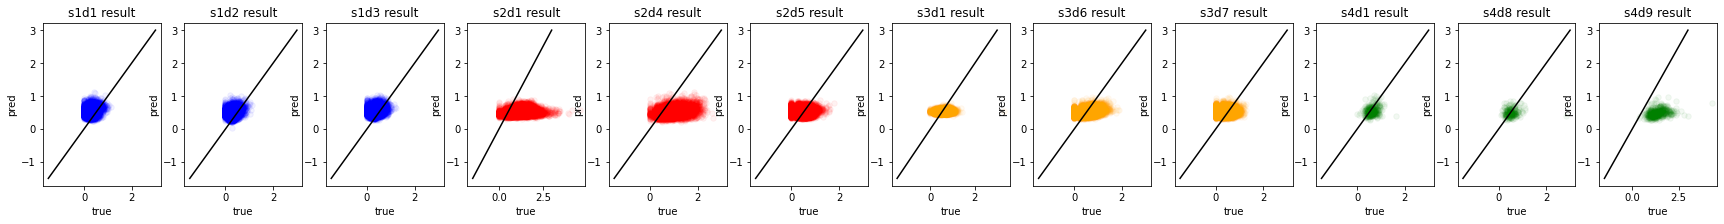

Epoch  3100 s1d1:  0.30563414 s1d2:  0.2956203 s1d3:  0.2992054 s2d1: 0.8368398 s2d4: 0.6059101 s2d5: 0.32727286 s3d1: 0.20233418 s3d6: 0.29315642 s3d7: 0.3136877 s4d1: 0.20562242 s4d8: 0.26620236 s4d9: 0.9535255 test loss: 0.6679208663653764
Epoch  3200 s1d1:  0.30586028 s1d2:  0.2957321 s1d3:  0.29955146 s2d1: 0.83650035 s2d4: 0.60610837 s2d5: 0.32752597 s3d1: 0.20229223 s3d6: 0.29300067 s3d7: 0.31393164 s4d1: 0.2059875 s4d8: 0.26636958 s4d9: 0.95438963 test loss: 0.668538459644405
Epoch  3300 s1d1:  0.30598006 s1d2:  0.29581028 s1d3:  0.29990166 s2d1: 0.8361482 s2d4: 0.60631853 s2d5: 0.32780567 s3d1: 0.20225312 s3d6: 0.2928474 s3d7: 0.31418234 s4d1: 0.20639691 s4d8: 0.26655918 s4d9: 0.9552902 test loss: 0.6691863376749493
Epoch  3400 s1d1:  0.3061624 s1d2:  0.29609683 s1d3:  0.30027726 s2d1: 0.83590966 s2d4: 0.6064589 s2d5: 0.32810193 s3d1: 0.20228888 s3d6: 0.29269347 s3d7: 0.31451106 s4d1: 0.20675601 s4d8: 0.26682004 s4d9: 0.95599794 test loss: 0.6697086030004402
Epoch  3500 s1d1: 

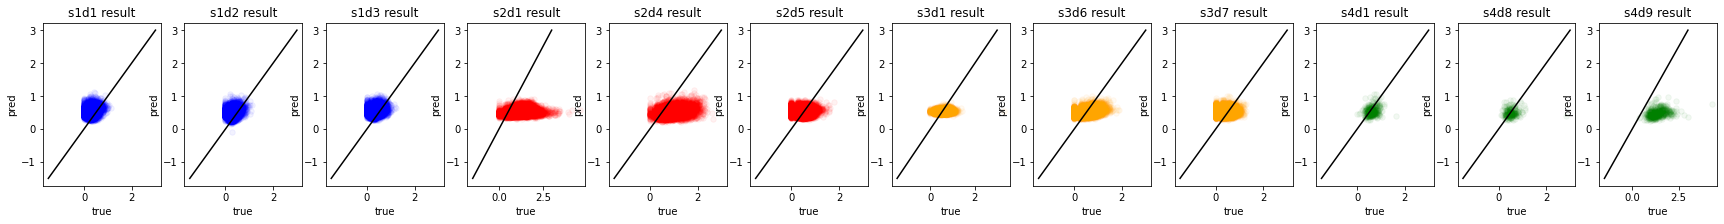

Epoch  4100 s1d1:  0.30784103 s1d2:  0.29879338 s1d3:  0.30300546 s2d1: 0.83430505 s2d4: 0.6070193 s2d5: 0.32966384 s3d1: 0.20207821 s3d6: 0.2916413 s3d7: 0.31665906 s4d1: 0.20881702 s4d8: 0.26848298 s4d9: 0.96035326 test loss: 0.6729122616223385
Epoch  4200 s1d1:  0.30855083 s1d2:  0.29960194 s1d3:  0.30377647 s2d1: 0.8340049 s2d4: 0.60680693 s2d5: 0.32984164 s3d1: 0.20201237 s3d6: 0.29149133 s3d7: 0.3170227 s4d1: 0.20901339 s4d8: 0.2688036 s4d9: 0.96053004 test loss: 0.6730749096348078
Epoch  4300 s1d1:  0.3087108 s1d2:  0.29994988 s1d3:  0.30405024 s2d1: 0.83396304 s2d4: 0.60691047 s2d5: 0.32995456 s3d1: 0.20200285 s3d6: 0.29134512 s3d7: 0.31732357 s4d1: 0.20932117 s4d8: 0.26908833 s4d9: 0.9610995 test loss: 0.6735033905494245
Epoch  4400 s1d1:  0.30908453 s1d2:  0.300759 s1d3:  0.30451402 s2d1: 0.83387494 s2d4: 0.6068608 s2d5: 0.3301976 s3d1: 0.20205334 s3d6: 0.2912034 s3d7: 0.31763193 s4d1: 0.20954221 s4d8: 0.2693867 s4d9: 0.9612707 test loss: 0.6736631555213048
Epoch  4500 s1d1: 

In [35]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d6, pro_s3d6)

Epoch  0 s1d1:  0.26841637 s1d2:  0.2623685 s1d3:  0.2819206 s2d1: 1.2567143 s2d4: 0.9551427 s2d5: 0.5254354 s3d1: 0.5921323 s3d6: 0.59035707 s3d7: 0.4022707 s4d1: 0.47896466 s4d8: 0.44067562 s4d9: 1.2850401 test loss: 0.9352967438293129


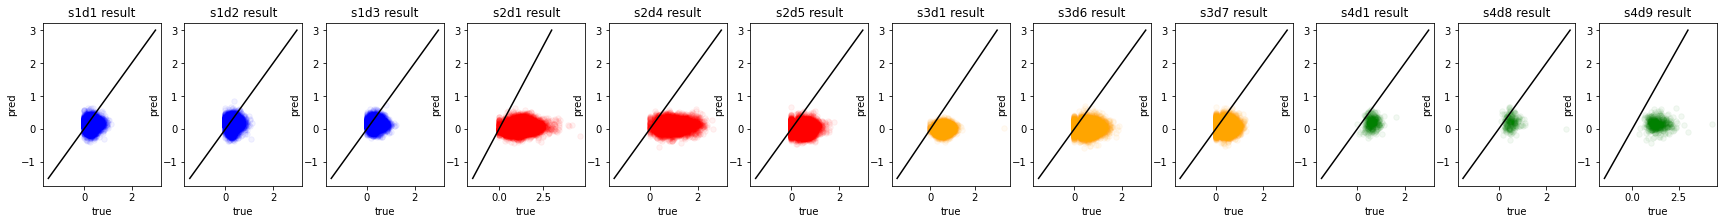

Epoch  100 s1d1:  0.20714343 s1d2:  0.2129468 s1d3:  0.21332973 s2d1: 1.0743995 s2d4: 0.76801705 s2d5: 0.35546118 s3d1: 0.3917318 s3d6: 0.41563168 s3d7: 0.25994873 s4d1: 0.30405244 s4d8: 0.29971454 s4d9: 1.1022284 test loss: 0.7791756259029985
Epoch  200 s1d1:  0.20599009 s1d2:  0.2083296 s1d3:  0.20793286 s2d1: 1.0568252 s2d4: 0.7509574 s2d5: 0.34297577 s3d1: 0.3699031 s3d6: 0.40116167 s3d7: 0.25438577 s4d1: 0.2964191 s4d8: 0.29149088 s4d9: 1.0884801 test loss: 0.7686045501655492
Epoch  300 s1d1:  0.2036954 s1d2:  0.20538215 s1d3:  0.20583914 s2d1: 1.0495287 s2d4: 0.7470689 s2d5: 0.33618698 s3d1: 0.35866094 s3d6: 0.393423 s3d7: 0.25154036 s4d1: 0.296775 s4d8: 0.2887317 s4d9: 1.0848308 test loss: 0.7660624581103778
Epoch  400 s1d1:  0.20196968 s1d2:  0.203441 s1d3:  0.20457073 s2d1: 1.0442383 s2d4: 0.74552214 s2d5: 0.33152494 s3d1: 0.35080475 s3d6: 0.38793203 s3d7: 0.24972418 s4d1: 0.29815653 s4d8: 0.28753912 s4d9: 1.0825443 test loss: 0.7646628707264089
Epoch  500 s1d1:  0.20091785 s1

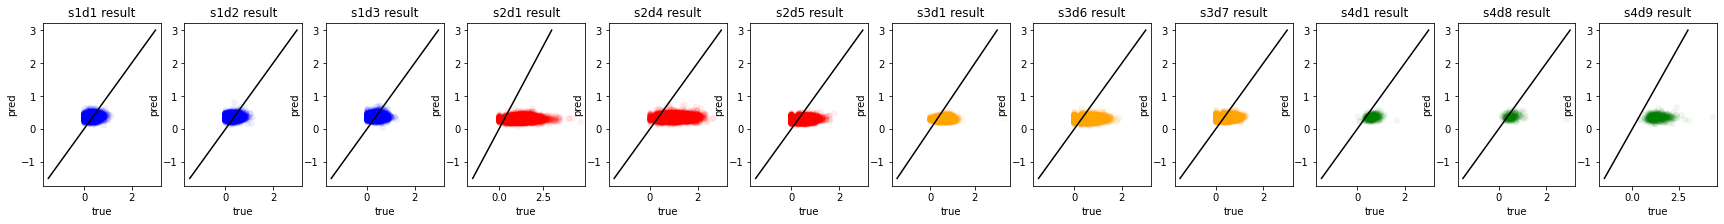

Epoch  1100 s1d1:  0.19813584 s1d2:  0.19576274 s1d3:  0.20136167 s2d1: 1.020166 s2d4: 0.7444502 s2d5: 0.3166521 s3d1: 0.32025287 s3d6: 0.36988583 s3d7: 0.24515782 s4d1: 0.30667424 s4d8: 0.28848398 s4d9: 1.0793658 test loss: 0.7637987974359347
Epoch  1200 s1d1:  0.19780733 s1d2:  0.19500011 s1d3:  0.2011215 s2d1: 1.0181578 s2d4: 0.744639 s2d5: 0.31563553 s3d1: 0.31806827 s3d6: 0.36867246 s3d7: 0.2449268 s4d1: 0.3075475 s4d8: 0.28905618 s4d9: 1.0797199 test loss: 0.7641904622171299
Epoch  1300 s1d1:  0.19766584 s1d2:  0.19443671 s1d3:  0.20100486 s2d1: 1.0162375 s2d4: 0.744676 s2d5: 0.3147642 s3d1: 0.31598672 s3d6: 0.3675538 s3d7: 0.2447331 s4d1: 0.30812123 s4d8: 0.28942865 s4d9: 1.0797422 test loss: 0.7643112887803698
Epoch  1400 s1d1:  0.19746466 s1d2:  0.19384967 s1d3:  0.20087378 s2d1: 1.0146735 s2d4: 0.7449388 s2d5: 0.31406644 s3d1: 0.31420356 s3d6: 0.36665887 s3d7: 0.24456929 s4d1: 0.30880234 s4d8: 0.28990912 s4d9: 1.0799949 test loss: 0.764604607116358
Epoch  1500 s1d1:  0.197319

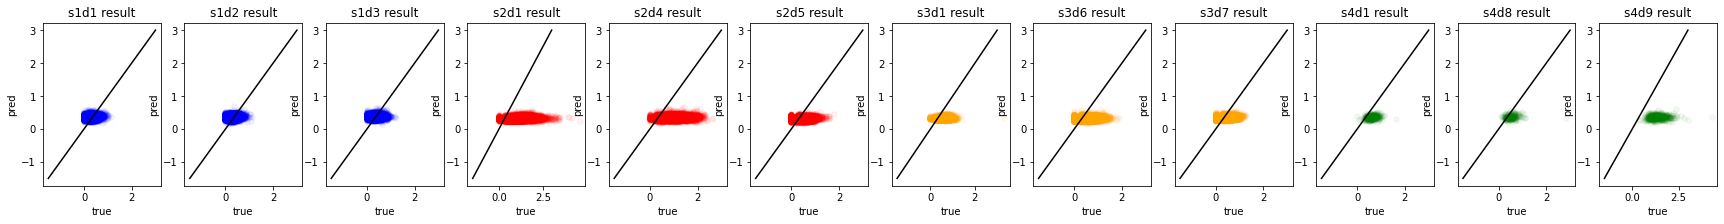

Epoch  2100 s1d1:  0.19670859 s1d2:  0.19152133 s1d3:  0.20024393 s2d1: 1.0078297 s2d4: 0.7458841 s2d5: 0.31107256 s3d1: 0.30649546 s3d6: 0.36287984 s3d7: 0.24386269 s4d1: 0.3120244 s4d8: 0.29267335 s4d9: 1.0812861 test loss: 0.7660956481791039
Epoch  2200 s1d1:  0.19667923 s1d2:  0.19135116 s1d3:  0.20021991 s2d1: 1.0074058 s2d4: 0.74613607 s2d5: 0.3108845 s3d1: 0.30593878 s3d6: 0.36267495 s3d7: 0.24379294 s4d1: 0.31250727 s4d8: 0.2930848 s4d9: 1.08159 test loss: 0.7663908388764021
Epoch  2300 s1d1:  0.19677944 s1d2:  0.19134797 s1d3:  0.20028776 s2d1: 1.0067989 s2d4: 0.74603957 s2d5: 0.31066245 s3d1: 0.30527297 s3d6: 0.36236626 s3d7: 0.24372505 s4d1: 0.31257668 s4d8: 0.29318652 s4d9: 1.0813768 test loss: 0.766270221543336
Epoch  2400 s1d1:  0.19683717 s1d2:  0.19128597 s1d3:  0.20034775 s2d1: 1.0062805 s2d4: 0.7461881 s2d5: 0.31049317 s3d1: 0.30483449 s3d6: 0.3621495 s3d7: 0.24366206 s4d1: 0.3128761 s4d8: 0.2934565 s4d9: 1.0814656 test loss: 0.7663899385931041
Epoch  2500 s1d1:  0.19

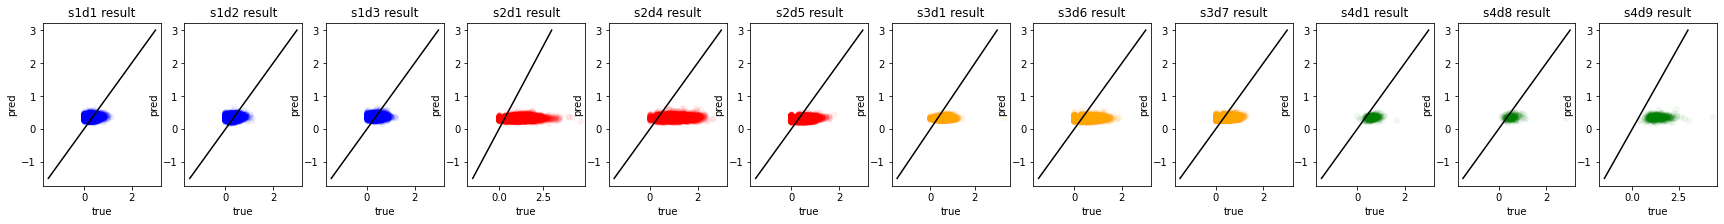

Epoch  3100 s1d1:  0.19745986 s1d2:  0.19130006 s1d3:  0.20092514 s2d1: 1.0037616 s2d4: 0.746754 s2d5: 0.30977577 s3d1: 0.30276704 s3d6: 0.3610883 s3d7: 0.24324577 s4d1: 0.3141385 s4d8: 0.29475072 s4d9: 1.0815964 test loss: 0.7667498546939292
Epoch  3200 s1d1:  0.1976498 s1d2:  0.19143686 s1d3:  0.20110205 s2d1: 1.0035639 s2d4: 0.7469459 s2d5: 0.30972868 s3d1: 0.30272666 s3d6: 0.36103377 s3d7: 0.24318743 s4d1: 0.31435132 s4d8: 0.29493454 s4d9: 1.0816678 test loss: 0.7668398561105977
Epoch  3300 s1d1:  0.19772486 s1d2:  0.19145276 s1d3:  0.20120794 s2d1: 1.0033479 s2d4: 0.7471002 s2d5: 0.30968332 s3d1: 0.30249032 s3d6: 0.36094362 s3d7: 0.24312925 s4d1: 0.31468204 s4d8: 0.29520398 s4d9: 1.0818669 test loss: 0.7670354988715196
Epoch  3400 s1d1:  0.19781625 s1d2:  0.19147767 s1d3:  0.20131043 s2d1: 1.0031078 s2d4: 0.74730134 s2d5: 0.30963856 s3d1: 0.30229113 s3d6: 0.3608668 s3d7: 0.2430724 s4d1: 0.3149352 s4d8: 0.2954975 s4d9: 1.0821102 test loss: 0.7672511132665085
Epoch  3500 s1d1:  0.19

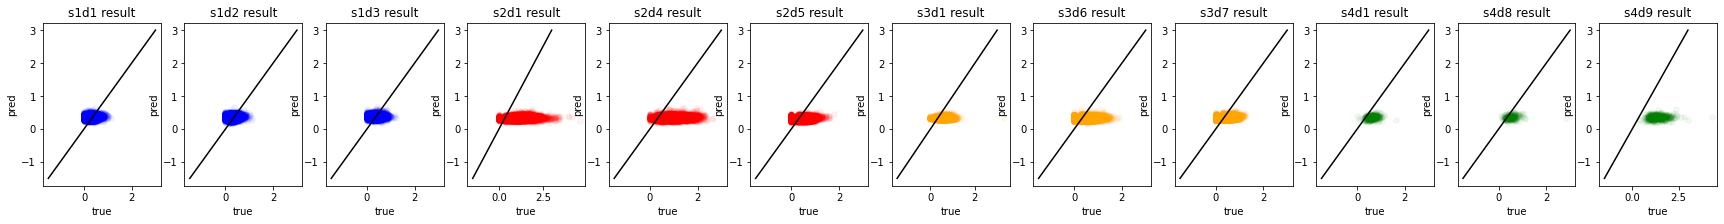

Epoch  4100 s1d1:  0.19866537 s1d2:  0.19217585 s1d3:  0.20211378 s2d1: 1.0027645 s2d4: 0.7487197 s2d5: 0.30973223 s3d1: 0.30242658 s3d6: 0.3608311 s3d7: 0.24266195 s4d1: 0.31688488 s4d8: 0.2971285 s4d9: 1.0834173 test loss: 0.7684953099038183
Epoch  4200 s1d1:  0.19891408 s1d2:  0.19241597 s1d3:  0.20234127 s2d1: 1.0027221 s2d4: 0.7488292 s2d5: 0.30976847 s3d1: 0.30241856 s3d6: 0.3608216 s3d7: 0.24260283 s4d1: 0.31701612 s4d8: 0.2972603 s4d9: 1.083378 test loss: 0.7684984864525295
Epoch  4300 s1d1:  0.19917206 s1d2:  0.1926635 s1d3:  0.20256561 s2d1: 1.0026315 s2d4: 0.748879 s2d5: 0.30980396 s3d1: 0.30244324 s3d6: 0.360796 s3d7: 0.24254285 s4d1: 0.3171065 s4d8: 0.29735336 s4d9: 1.0832897 test loss: 0.7684612868677537
Epoch  4400 s1d1:  0.19931944 s1d2:  0.19280061 s1d3:  0.2027257 s2d1: 1.0026963 s2d4: 0.74921143 s2d5: 0.3098789 s3d1: 0.30261526 s3d6: 0.3608333 s3d7: 0.2424842 s4d1: 0.31747836 s4d8: 0.29764622 s4d9: 1.083522 test loss: 0.7686862811473504
Epoch  4500 s1d1:  0.19944216 

In [36]:
num_epochs = 5000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, RNA_s3d7, pro_s3d7)